# BigContest EDA with activity

# 1. Set Environment

## 1.1 Load library

In [2]:
library(data.table) # Data load
library(dplyr) # Preprocessing
library(stringr) # Preprocessing
library(tidyr) # Preprocessing
library(ggplot2) # Visualization
library(corrplot) # Visualization
library(GGally) # Visualization

## 1.2 Load data

In [3]:
activity <- fread("data/futureleague/reform/train_activity_new.csv", stringsAsFactors = F)
label    <- fread("data/futureleague/reform/train_label.csv", stringsAsFactors = F) %>% 
  mutate(label = factor(label, levels = c("retained", "2month", "month", "week")))
guild    <- fread("data/futureleague/reform/train_guild_new.csv", stringsAsFactors = F)

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:24


## 1.3 Predefined functions

In [57]:
label_week_heatmap <- function(df, target, is_normalized, sample_num) {
    df <- as.data.frame(df)
    df_temp <- df[, c("acc_id", "wk", target)]
    
    if (is_normalized == T) {
        df_temp[df_temp[, target] > 1, target] <- 1
    }
    
    df_temp2 <- df_temp %>% spread(key = "wk", value = target) %>%
      left_join(label, by = "acc_id")
    
    if (is_normalized == F) {
        df_temp2[is.na(df_temp2)] <- 0
    }
    names(df_temp2)[2:9] <- paste0("wk", 1:8)
    
    result <- df_temp2 %>% gather(key = "wk", value = target, -acc_id, -label) %>% arrange(label, acc_id, wk)
    
    id_list <- result %>% group_by(label) %>% sample_n(sample_num)
    sample_df <- result %>% filter(acc_id %in% id_list$acc_id)
    
    if (is_normalized == F) {
        p <- ggplot(sample_df, aes(wk, acc_id, fill = target)) + geom_tile() +
          scale_fill_distiller(name = target, palette = "Spectral", tran = "reverse") +
          ylim(unique(sample_df$acc_id)) +
          theme(axis.text.y = element_blank(), plot.title = element_text(hjust = 0.5)) + 
          facet_grid(. ~ label)
    } else {
        p <- ggplot(sample_df, aes(wk, acc_id, fill = target)) + geom_tile() +
          scale_fill_distiller(name = target, palette = "YlOrRd", tran = "reverse") +
          ylim(unique(sample_df$acc_id)) +
          theme(axis.text.y = element_blank(), plot.title = element_text(hjust = 0.5)) + 
          facet_grid(. ~ label)
    }
    
    return(p)
}

## 1.4 ETC setting

In [4]:
theme_set(theme_bw())
options(repr.plot.width = 10, repr.plot.height = 7)


유저 | 1주 | 2주 |$\rightarrow$| 합 | 평균 
-----|-----|-----|------------|----|------
A    |-0.1 | NA  |$\rightarrow$|-0.1|-0.1
B    |-0.1 |-0.2 |$\rightarrow$|-0.3|-0.15

# 2. EDA

## 2.1 Correlation

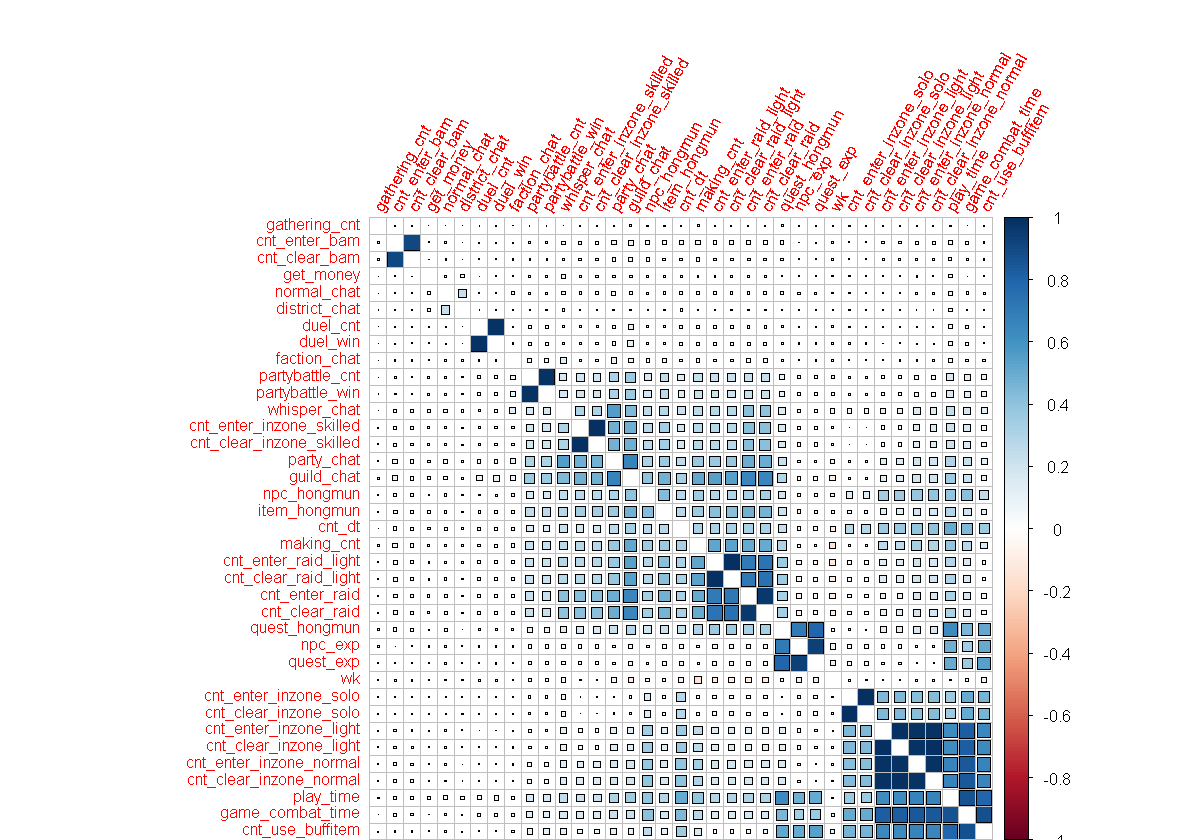

In [5]:
cor.df <- cor(activity %>% select(-activity_id, -acc_id))
corrplot(cor.df, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

## 2.2 Variable about Time
* wk
* cnt_dt
* play_time

       wk         cnt_dt       play_time        
 8      :100000   1: 52912   Min.   :-0.661667  
 7      : 62838   2: 51525   1st Qu.:-0.655209  
 5      : 52585   3: 55391   Median :-0.528866  
 4      : 51430   4: 51673   Mean   :-0.005621  
 6      : 50548   5: 60758   3rd Qu.: 0.339870  
 3      : 46122   6: 62494   Max.   : 5.320199  
 (Other): 76800   7:105570                      

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


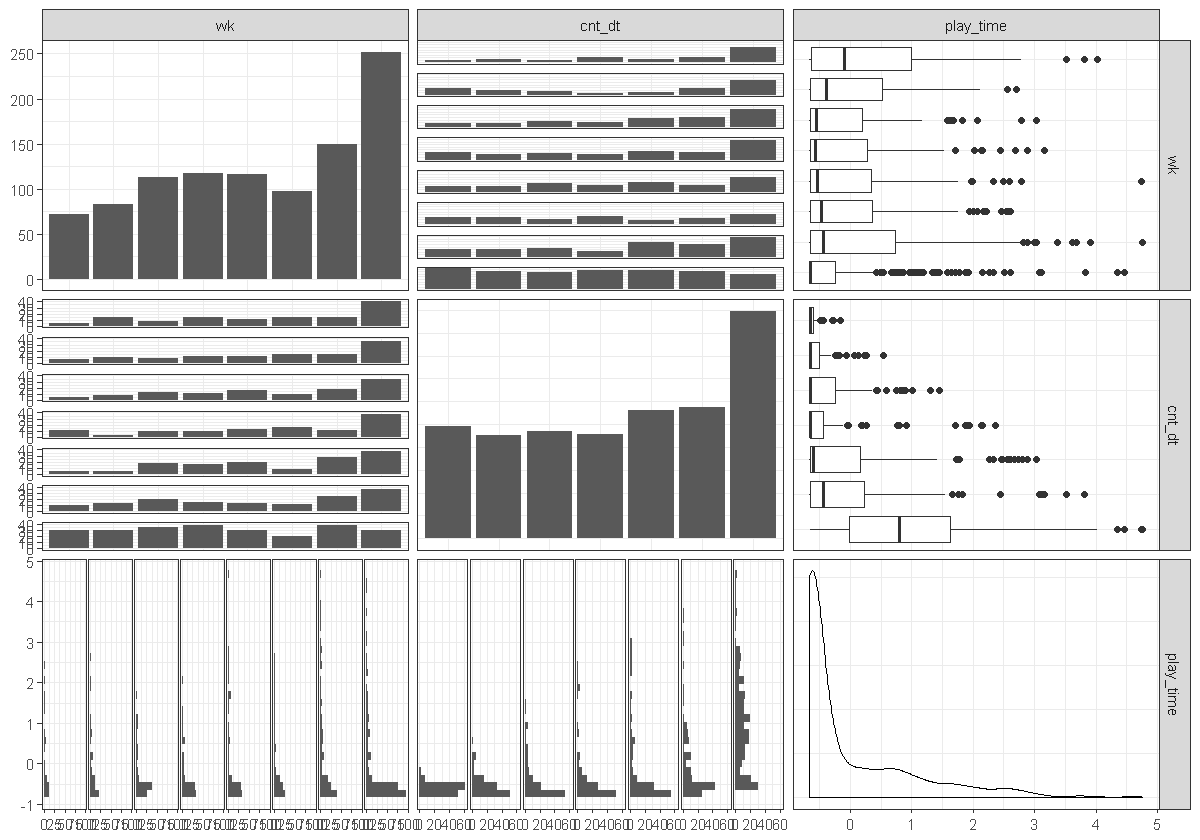

In [39]:
summary(activity %>% mutate(wk = factor(wk, ordered = T), cnt_dt = factor(cnt_dt, ordered = T)) %>% select(wk, cnt_dt, play_time))
ggpairs(activity %>% mutate(wk = factor(wk, ordered = T), cnt_dt = factor(cnt_dt, ordered = T)) %>% sample_n(1000),
       columns = c("wk", "cnt_dt", "play_time"))

In [7]:
time <- activity %>% group_by(acc_id) %>%
  summarize(wk_num = n(),
            access_num = sum(cnt_dt),
            access_mean = mean(cnt_dt),
            time_sum = sum(play_time),
            time_mean = mean(play_time)) %>%
  left_join(label, by = "acc_id"); head(time)

acc_id,wk_num,access_num,access_mean,time_sum,time_mean,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,12,6.000000,7.254976,3.6274881,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,25,3.125000,-5.285565,-0.6606956,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,12,2.400000,-3.285302,-0.6570603,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,31,5.166667,-3.019196,-0.5031993,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,3,1.500000,-1.310427,-0.6552137,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,39,4.875000,-3.891527,-0.4864409,month


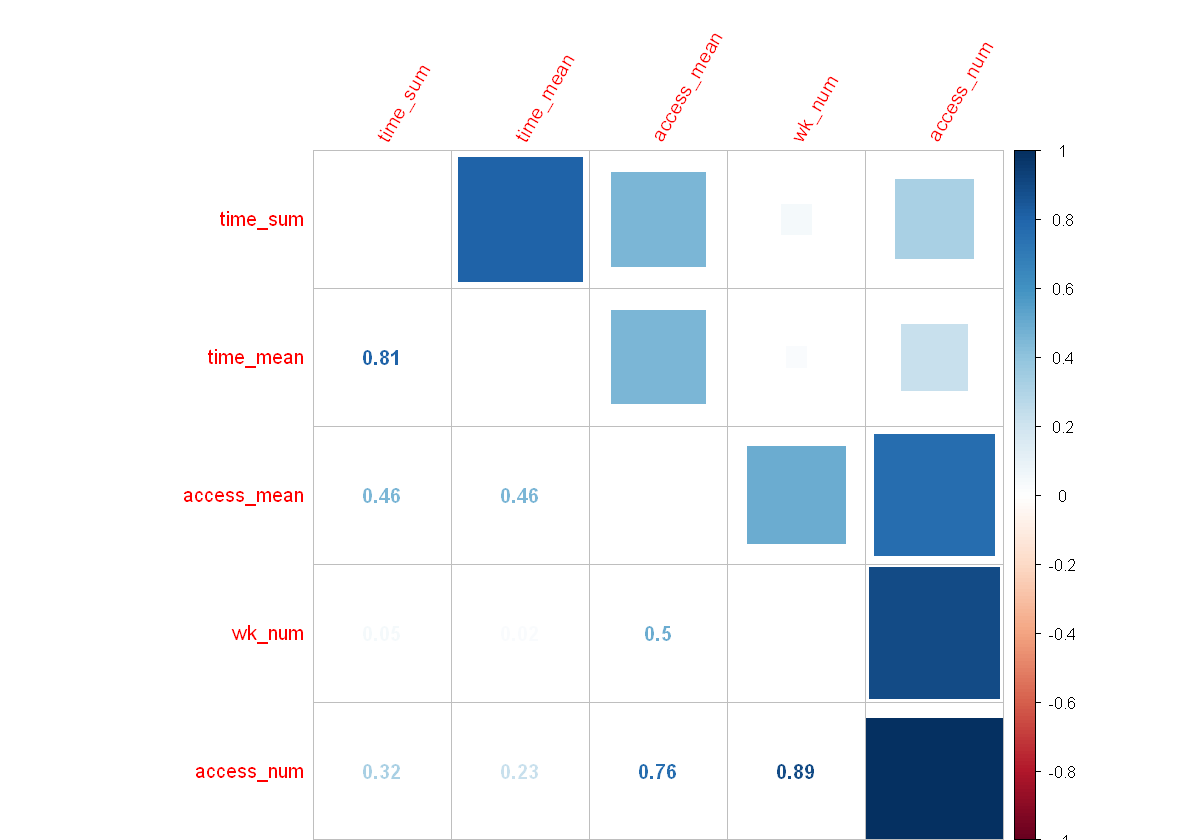

In [8]:
time.cor <- cor(time %>% select(-acc_id, -label))
corrplot.mixed(time.cor, lower = "number", upper = "square", diag = "n",
               tl.pos = "lt", order = "hclust", tl.srt = 60)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


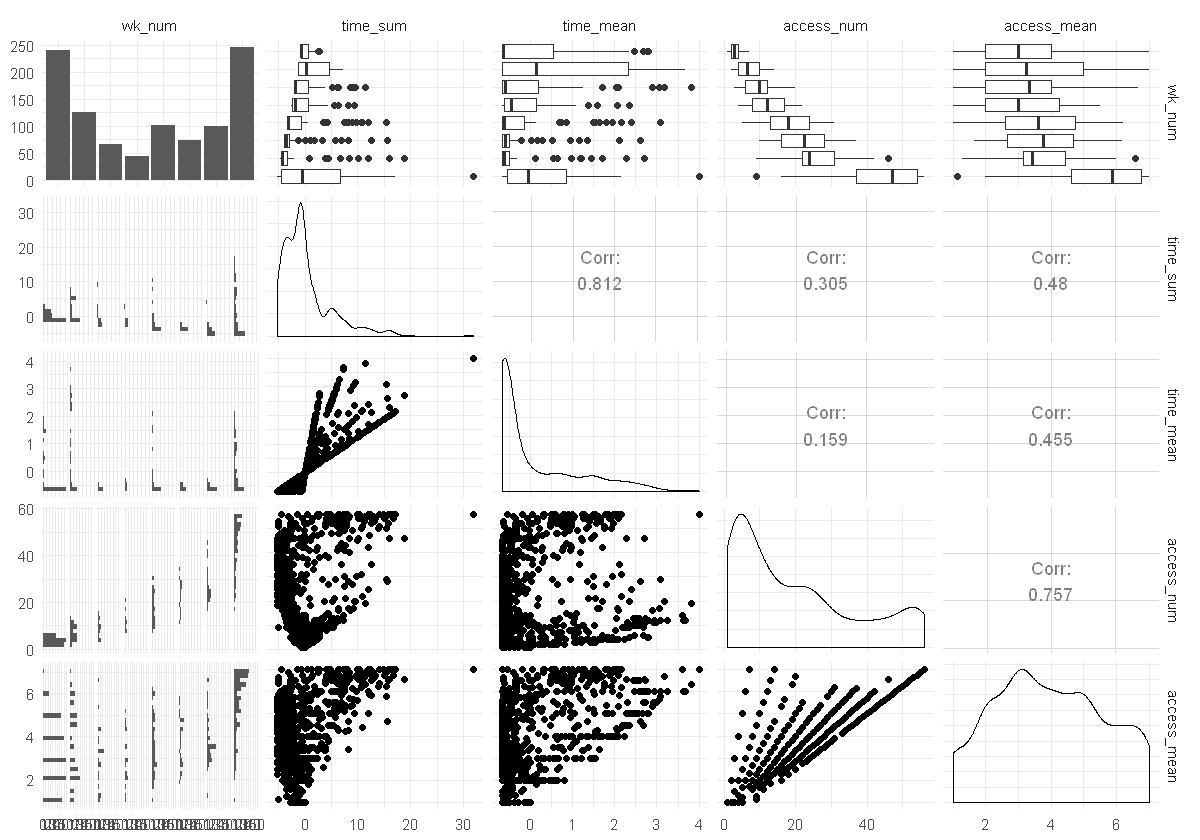

In [139]:
ggpairs(time %>% sample_n(1000), 
        columns = c("wk_num", "time_sum", "time_mean", "access_num", "access_mean"))

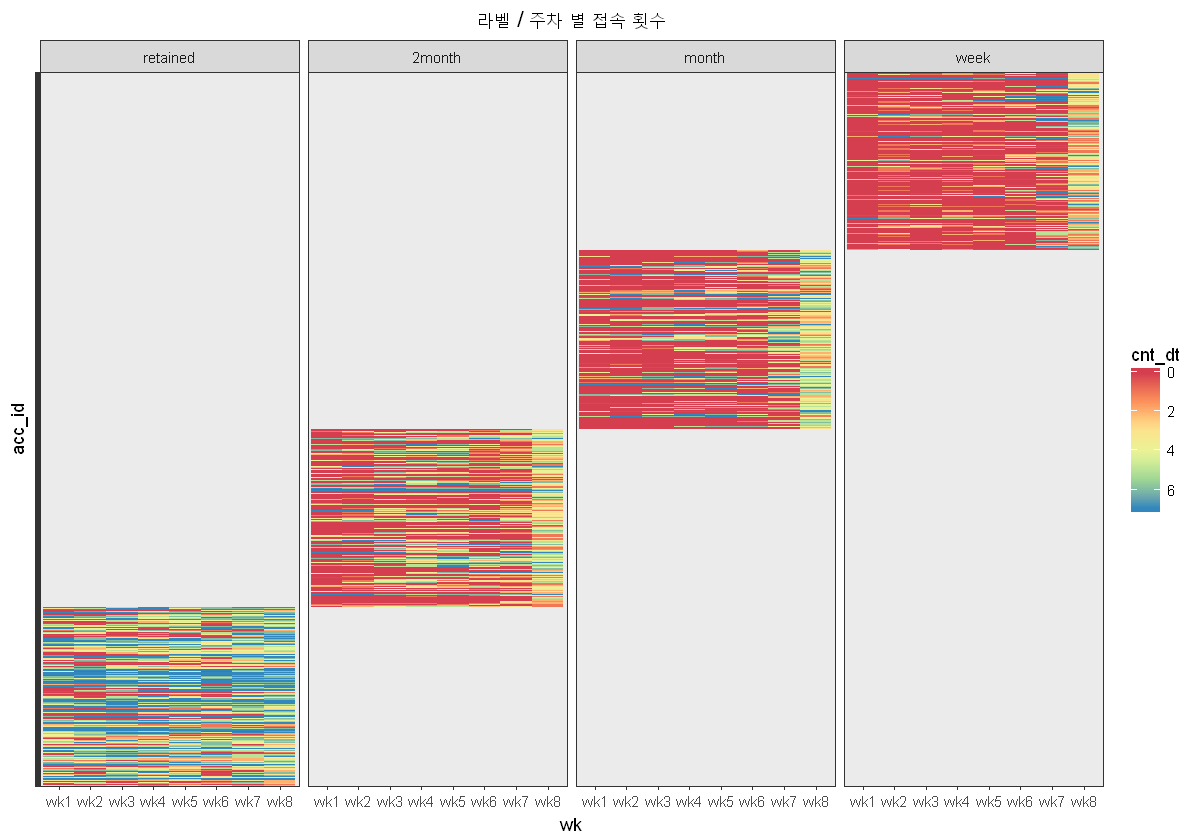

In [30]:
set.seed(1843)
label_week_heatmap(activity, "cnt_dt", is_normalized = F, sample_num = 2500) + labs(title = "라벨 / 주차 별 접속 횟수")

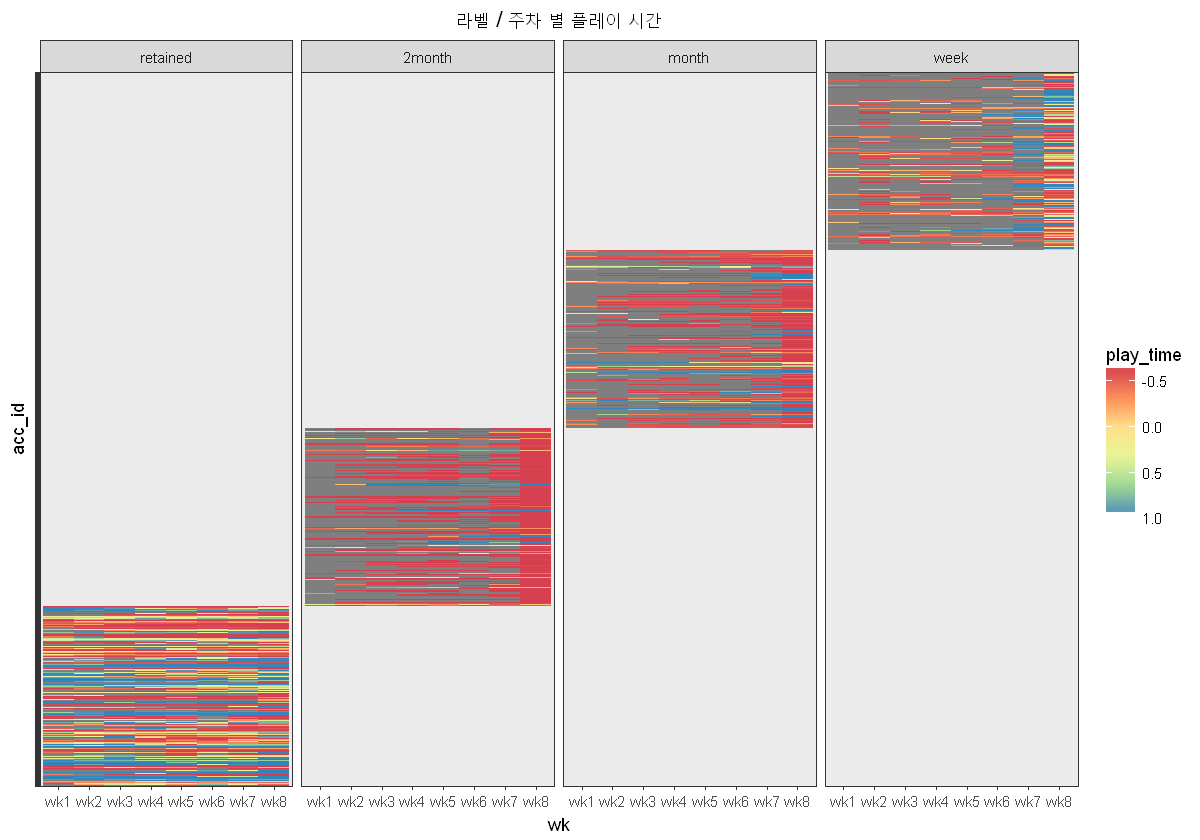

In [31]:
set.seed(8768)
label_week_heatmap(activity, "play_time", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 플레이 시간")

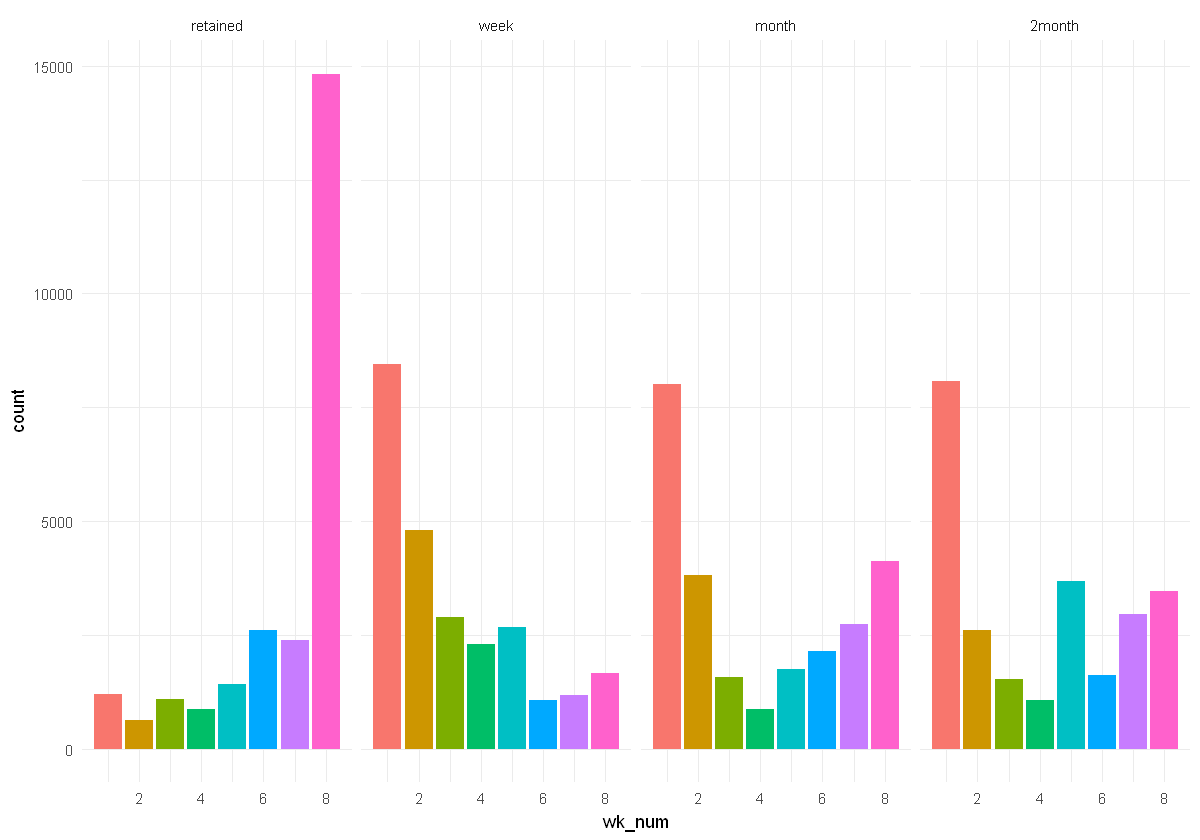

In [125]:
ggplot(time, aes(wk_num, fill = factor(wk_num))) +
  geom_bar() + facet_grid(. ~ label) + theme(legend.position = "none")

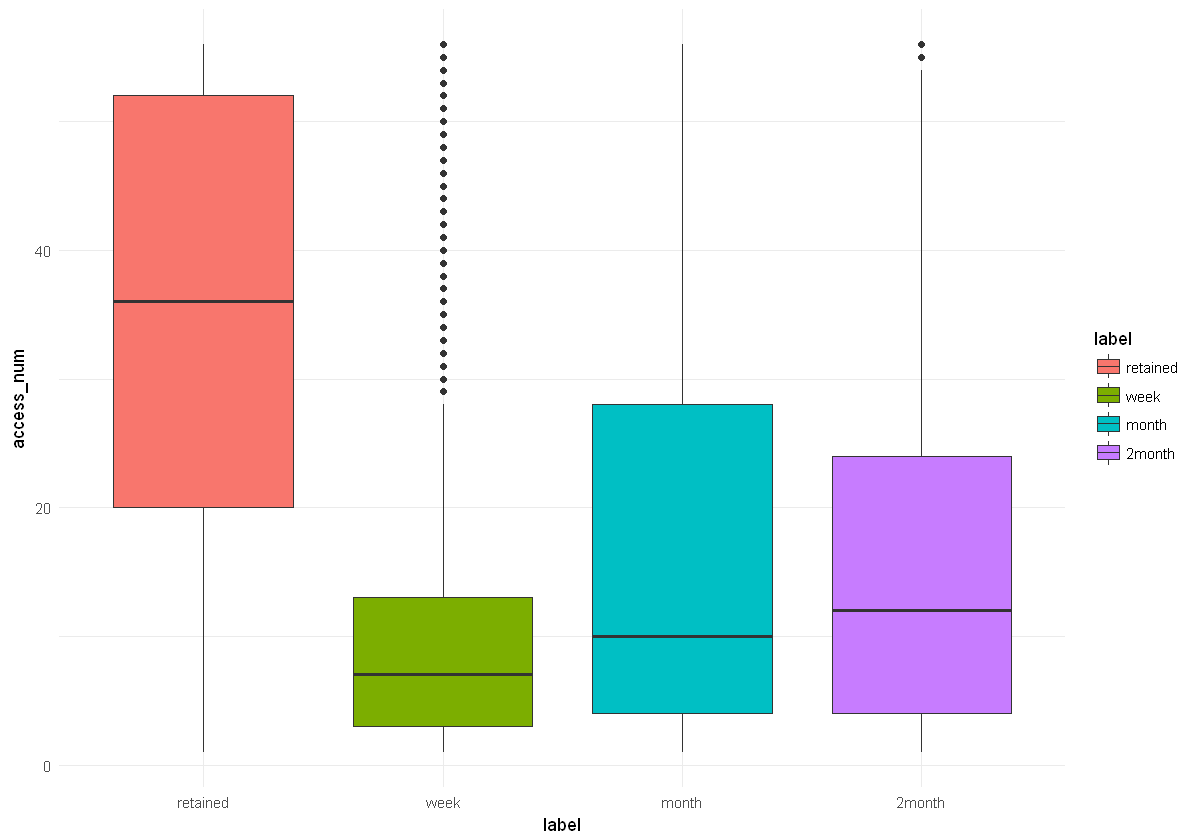

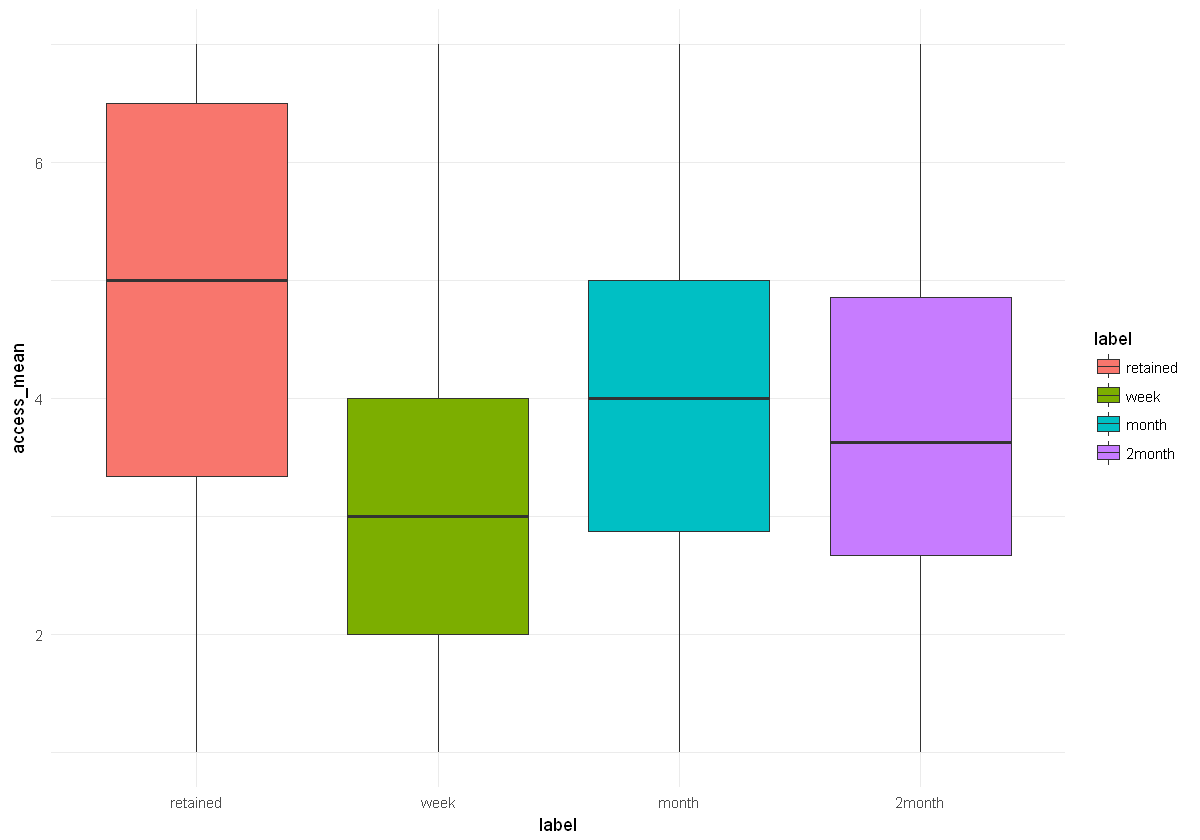

In [126]:
ggplot(time, aes(label, access_num, fill = label)) + geom_boxplot()
ggplot(time, aes(label, access_mean, fill = label)) + geom_boxplot()

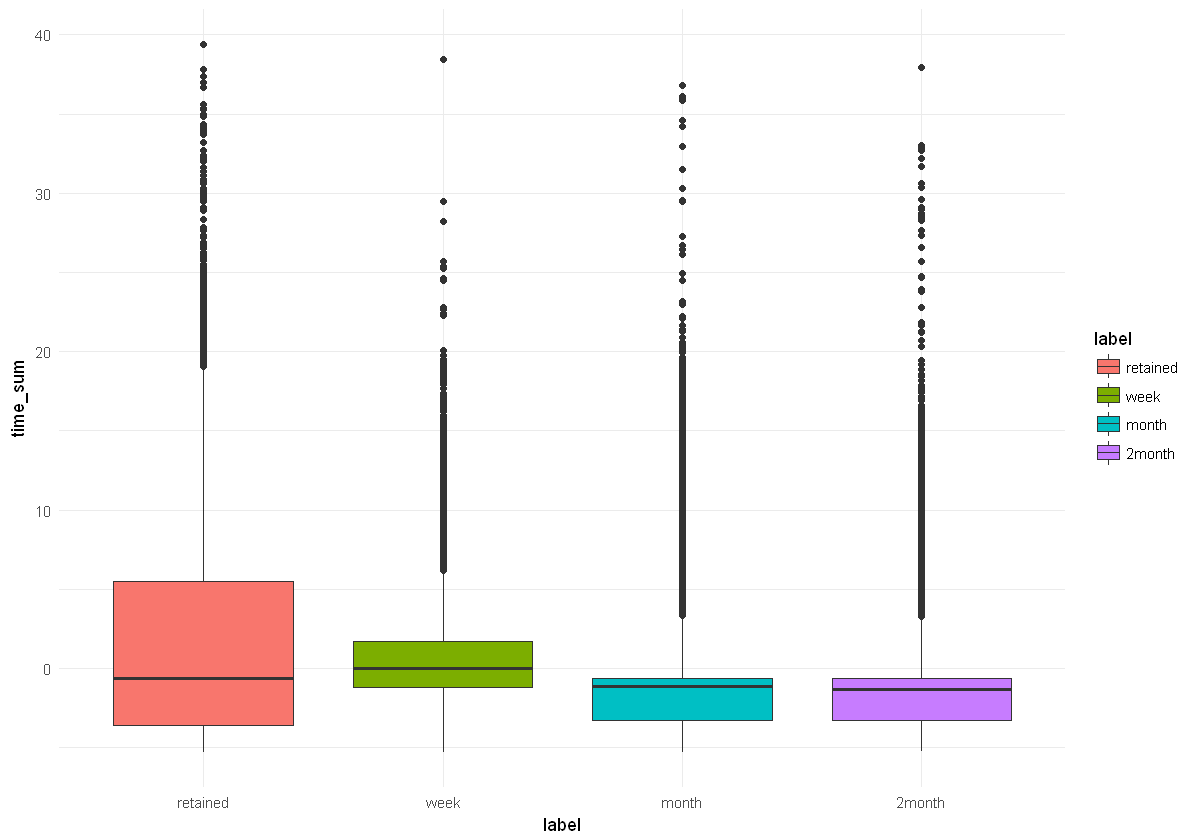

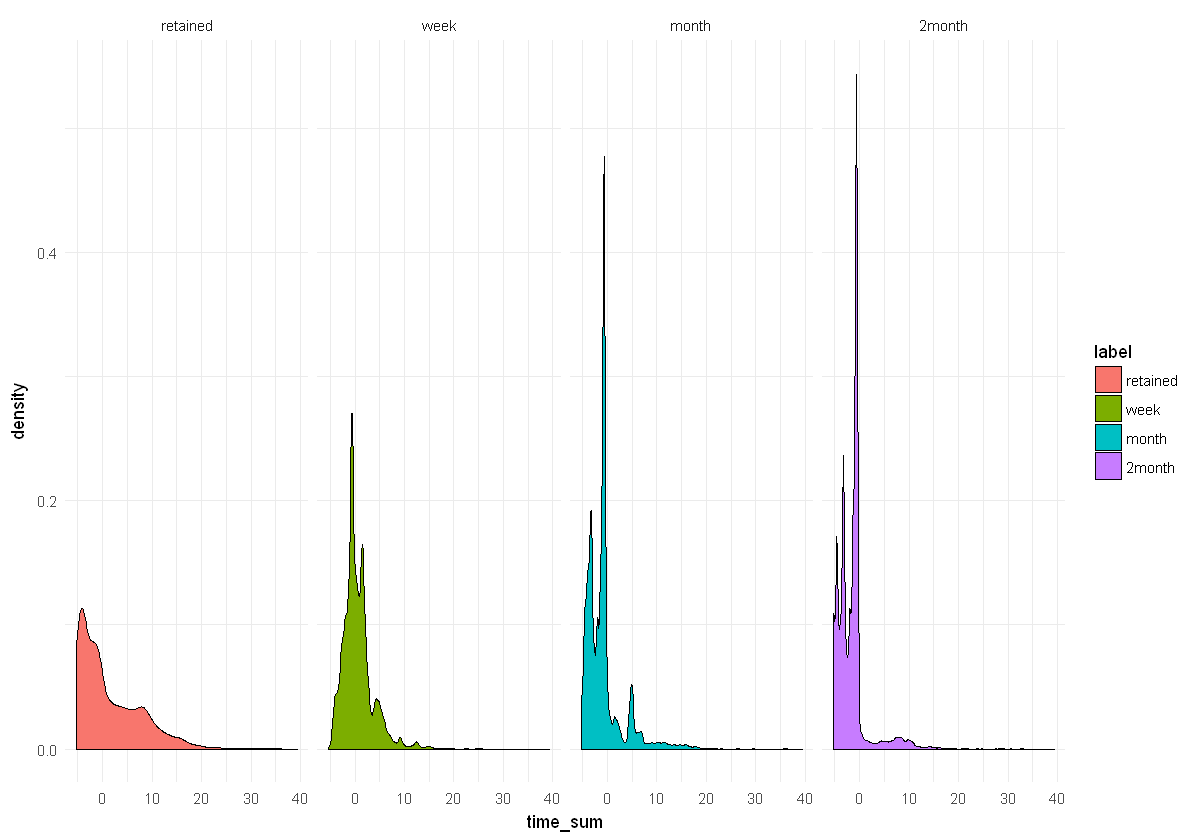

In [129]:
ggplot(time, aes(label, time_sum, fill = label)) + geom_boxplot()
ggplot(time, aes(time_sum, fill = label)) + geom_density() + facet_grid(. ~ label)

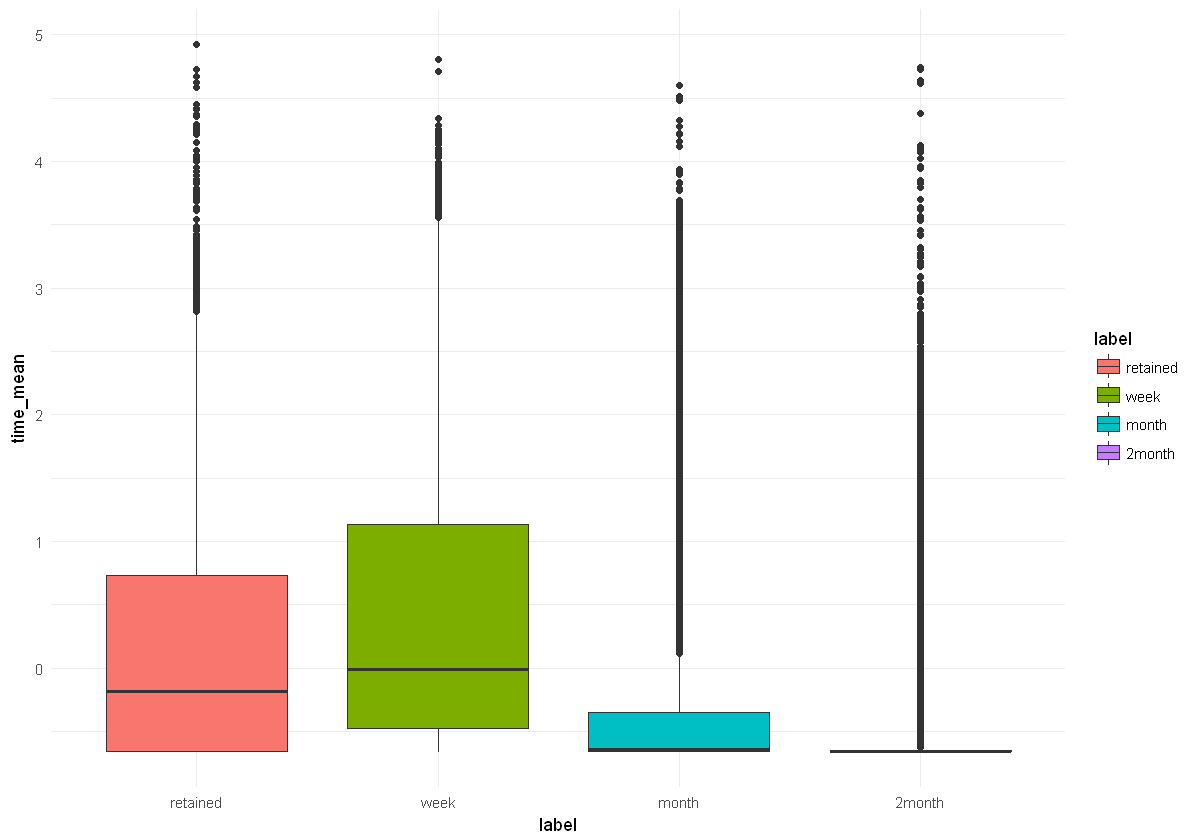

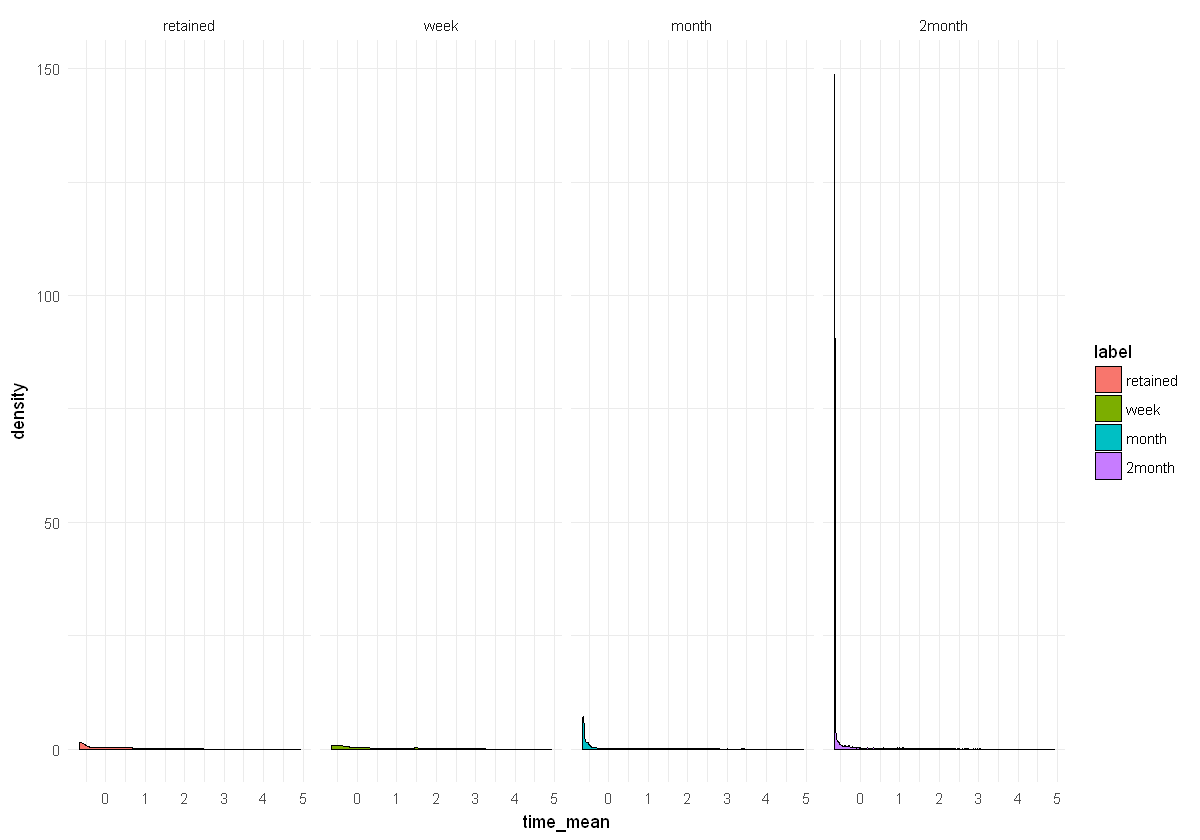

In [130]:
ggplot(time, aes(label, time_mean, fill = label)) + geom_boxplot()
ggplot(time, aes(time_mean, fill = label)) + geom_density() + facet_grid(. ~ label)

## 2.3 Variables about EXP
* npc_exp
* npc_hongmun
* quest_exp
* quest_hongmun
* item_hongmun

    npc_exp          npc_hongmun          quest_exp         quest_hongmun     
 Min.   :-0.23187   Min.   : -0.29080   Min.   :-0.250423   Min.   :-0.48767  
 1st Qu.:-0.23187   1st Qu.: -0.29080   1st Qu.:-0.250423   1st Qu.:-0.48767  
 Median :-0.23187   Median : -0.28259   Median :-0.250423   Median :-0.46057  
 Mean   :-0.00329   Mean   : -0.00330   Mean   :-0.003054   Mean   :-0.00494  
 3rd Qu.:-0.23187   3rd Qu.: -0.00614   3rd Qu.:-0.250423   3rd Qu.: 0.03390  
 Max.   :32.70345   Max.   :135.16662   Max.   :10.566449   Max.   :47.50375  
  item_hongmun     
 Min.   :-0.30635  
 1st Qu.:-0.30635  
 Median :-0.30635  
 Mean   :-0.00341  
 3rd Qu.:-0.11938  
 Max.   :61.82296  

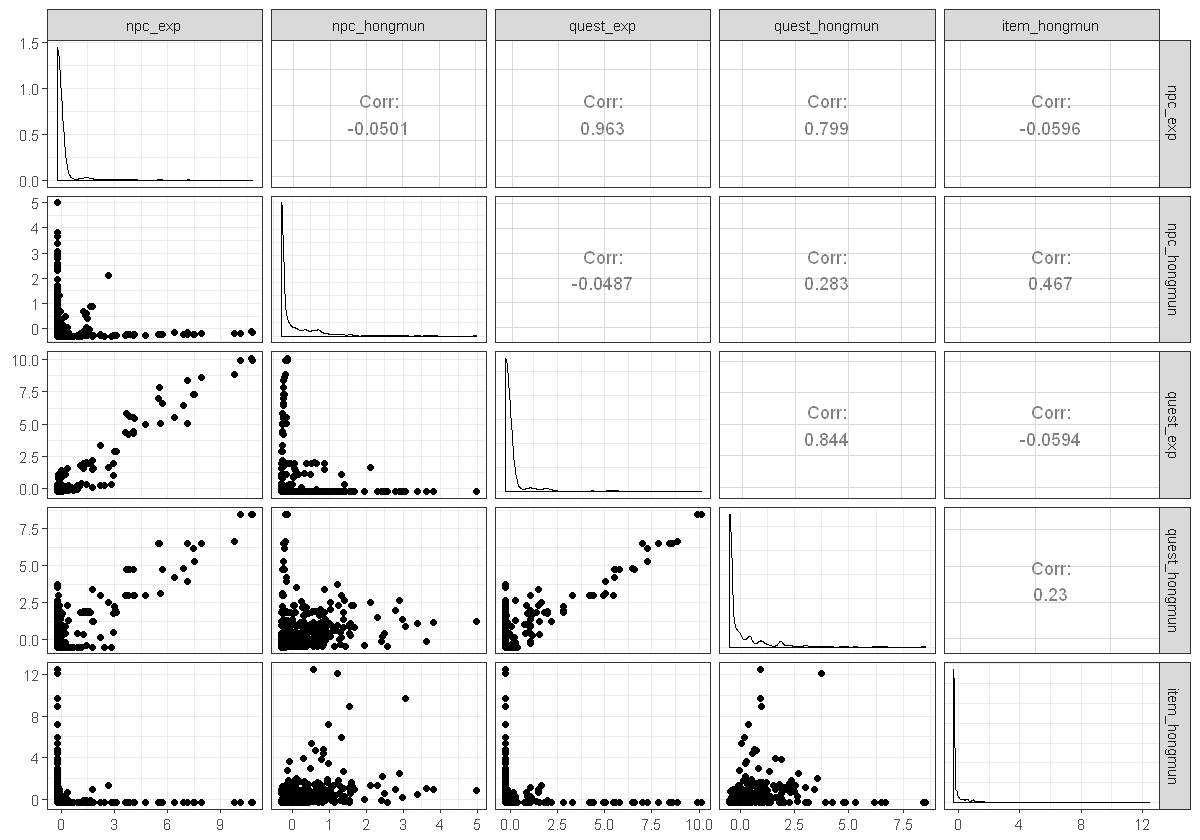

In [30]:
summary(activity %>% select(npc_exp, npc_hongmun, quest_exp, quest_hongmun, item_hongmun))
ggpairs(activity %>% sample_n(1000),
       columns = c("npc_exp", "npc_hongmun", "quest_exp", "quest_hongmun", "item_hongmun"))

* npc_exp와 npc_hongmun의 상관관계가 없음
* QUEST를 수행하면서 NPC 사냥도 같이 하기 때문에 npc_exp와 quest_exp의 상관관계가 높음
* QUEST를 완료하면 퀘스트 일반 경험치와 퀘스트 홍문 경험치를 같이 주기 때문에 npc_exp / quest_exp / quest_hongmun의 상관관계가 높음

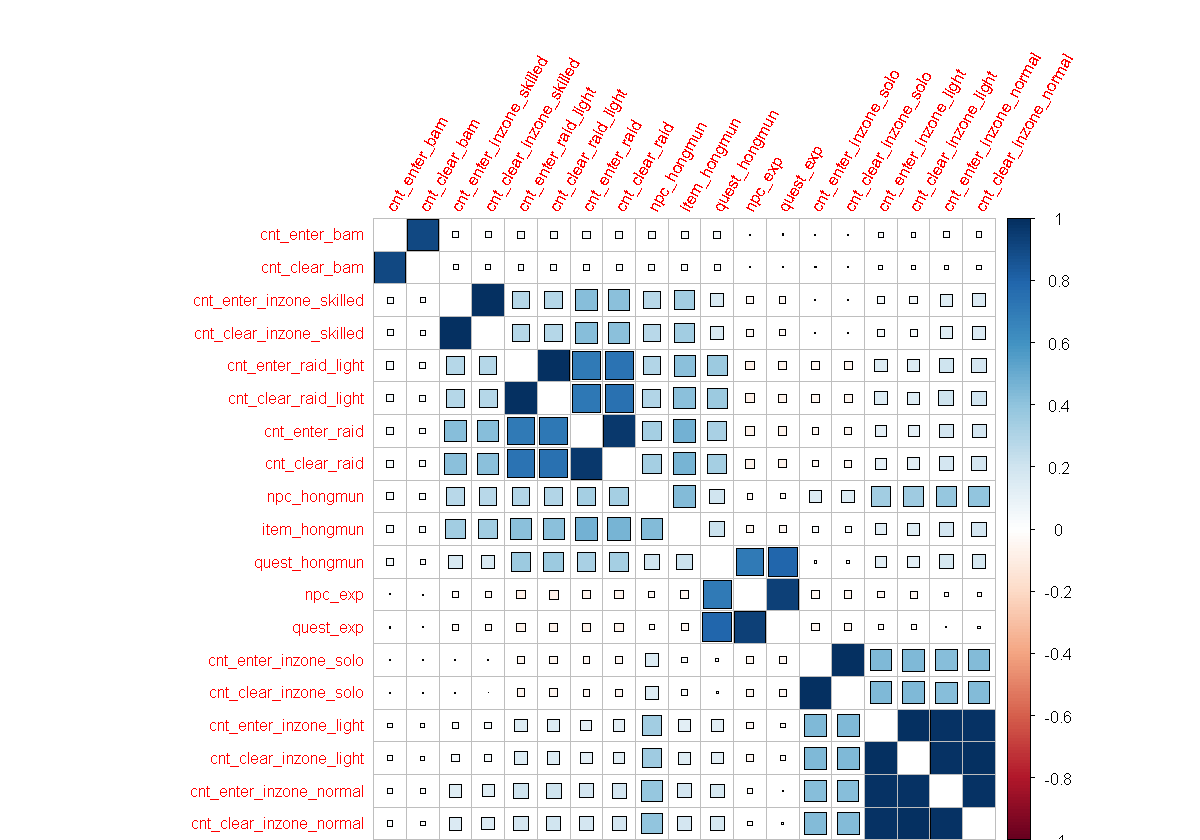

In [65]:
cor.df.temp <- cor(activity[,c(6,7,8,9,10,17:30)])
corrplot(cor.df.temp, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

* 일반 경험치의 경우 던전 관련 변수들과 상관관계가 매우 낮음
* 홍문 경험치의 경우 던전 관련 변수들과 상관관계가 어느정도 있음

* 초보 : quest와 npc 사냥으로 일반 경험치 획득 => 1레벨 ~ 55레벨
* 중수 : solo/light/normal inzone에서 quest와 npc 사냥으로 홍문 경험치 획득 => 1성 ~ 10성?
* 고수 : skilled inzone / raid / light raid에서 quest와 npc 사냥으로 홍문 경험치 획득 & item 홍문 경험치 획득

In [5]:
exp <- activity %>% group_by(acc_id) %>%
  summarize(mean_npc_exp = mean(npc_exp),
            sum_npc_exp = sum(npc_exp),
            mean_npc_hongmun = mean(npc_hongmun),
            sum_npc_hongmun = sum(npc_hongmun),
            mean_quest_exp = mean(quest_exp),
            sum_quest_exp = sum(quest_exp),
            mean_quest_hongmun = mean(quest_hongmun),
            sum_quest_hongmun = sum(quest_hongmun),
            mean_item_hongmun = mean(item_hongmun),
            sum_item_hongmun = sum(item_hongmun)) %>%
  left_join(label, by = "acc_id")
head(exp)

acc_id,mean_npc_exp,sum_npc_exp,mean_npc_hongmun,sum_npc_hongmun,mean_quest_exp,sum_quest_exp,mean_quest_hongmun,sum_quest_hongmun,mean_item_hongmun,sum_item_hongmun,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,6.0419654,12.0839307,-0.2382876,-0.4765752,6.82582813,13.6516563,4.9269363,9.8538726,-0.3063536,-0.6127072,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.2318740,-1.8549924,-0.2908032,-2.3264256,-0.25042336,-2.0033868,-0.4876662,-3.9013300,-0.3063536,-2.4508288,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.2317033,-1.1585167,-0.2908032,-1.4540160,-0.24953424,-1.2476712,-0.4876662,-2.4383312,-0.3063536,-1.5317680,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.1822994,-1.0937964,-0.2858753,-1.7152516,-0.02764767,-0.1658860,-0.1518956,-0.9113734,-0.3035836,-1.8215017,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.2314473,-0.4628946,-0.2908032,-0.5816064,-0.24820057,-0.4964011,-0.4876662,-0.9753325,-0.3063536,-0.6127072,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.2318740,-1.8549924,-0.2579845,-2.0638759,-0.25042336,-2.0033868,-0.4546304,-3.6370430,-0.2850594,-2.2804749,month


In [6]:
exp_temp <- exp %>% gather(key = "exp", value = "value", -acc_id, -label) %>%
  mutate(type = ifelse(str_detect(exp, "exp"), "normal", "hongmun"))
head(exp_temp)

acc_id,label,exp,value,type
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,week,mean_npc_exp,6.0419654,normal
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,retained,mean_npc_exp,-0.2318740,normal
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,retained,mean_npc_exp,-0.2317033,normal
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,month,mean_npc_exp,-0.1822994,normal
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2month,mean_npc_exp,-0.2314473,normal
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,month,mean_npc_exp,-0.2318740,normal


Warning message:
"Removed 83226 rows containing non-finite values (stat_boxplot)."

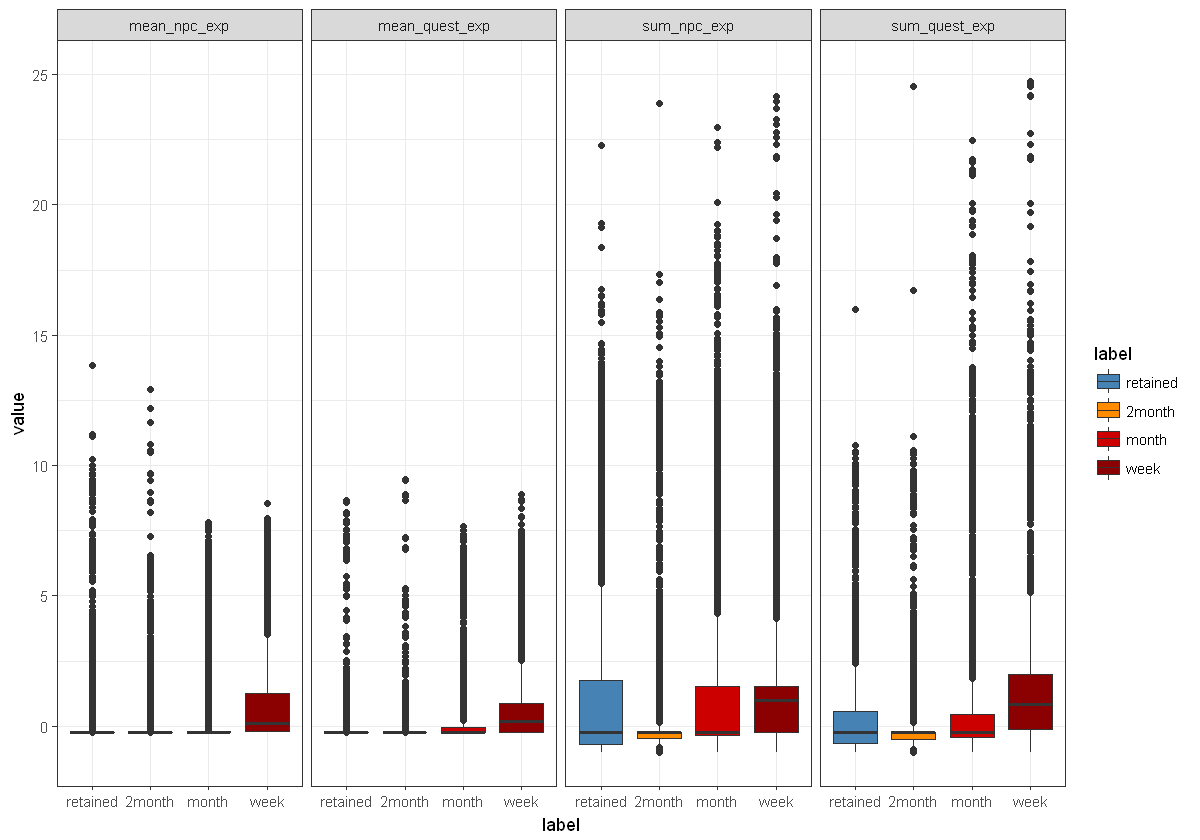

In [7]:
exp_temp %>% filter(type == "normal") %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  ylim(c(-1, 25)) + 
  facet_grid(. ~ exp, scale = "free")

Warning message:
"Removed 110225 rows containing non-finite values (stat_boxplot)."

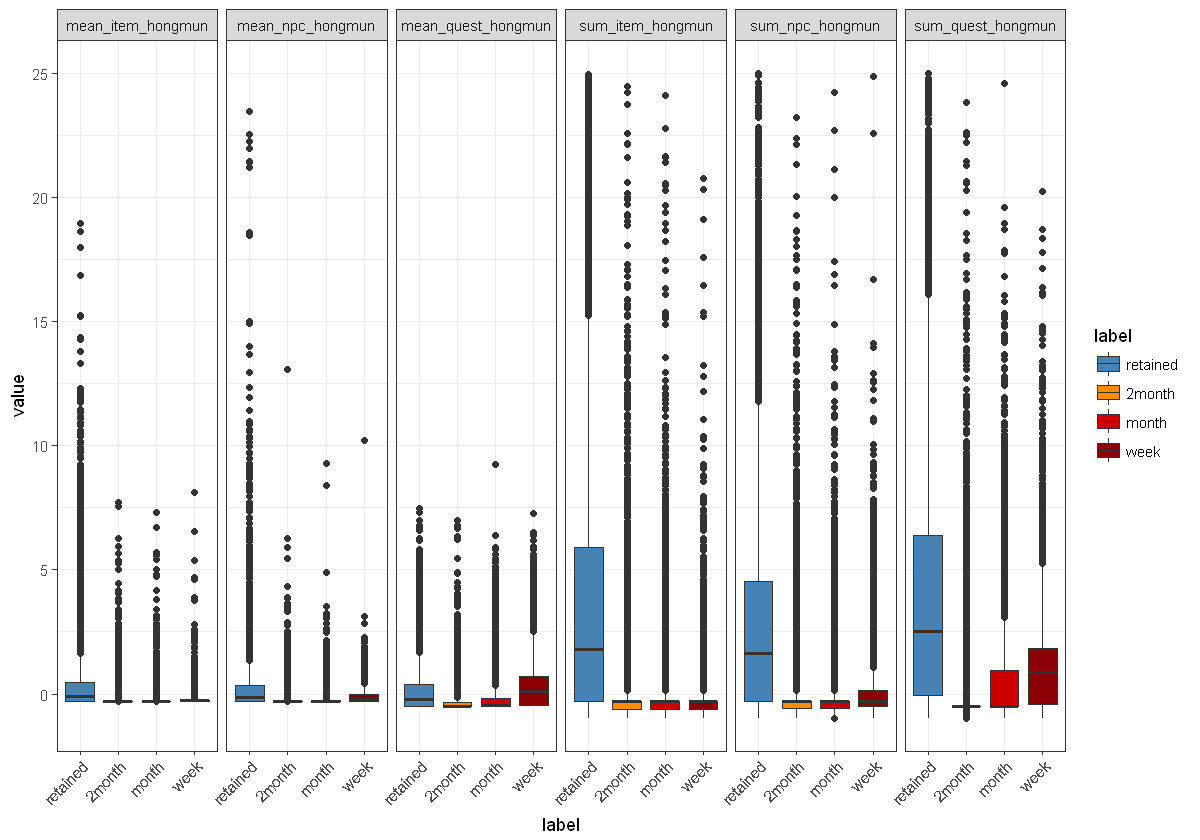

In [13]:
exp_temp %>% filter(type == "hongmun") %>%
  ggplot(aes(label, value, fill = label)) + geom_boxplot() +
  scale_fill_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(c(-1, 25)) + 
  facet_grid(. ~ exp, scales = "free")

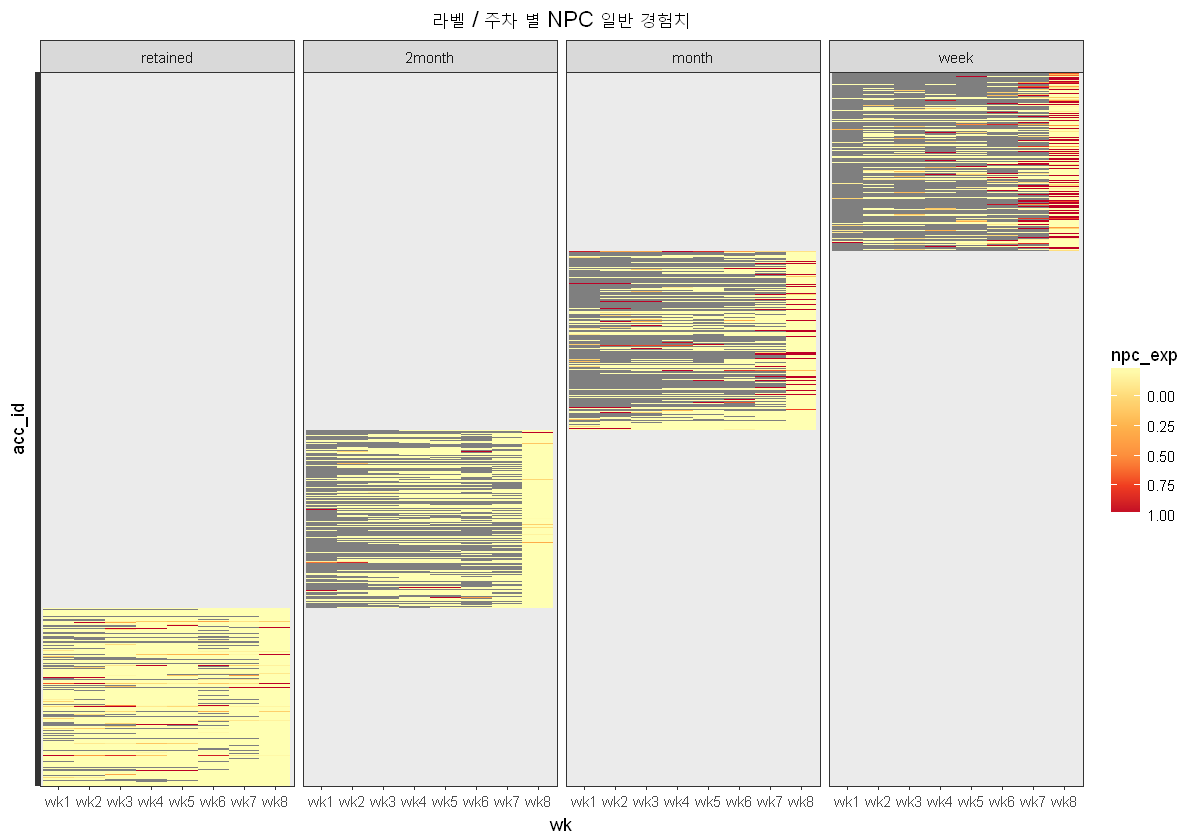

In [52]:
set.seed(6453)
label_week_heatmap(activity, "npc_exp", is_normalized = T, sample_num = 500) + labs(title = "라벨 / 주차 별 NPC 일반 경험치")

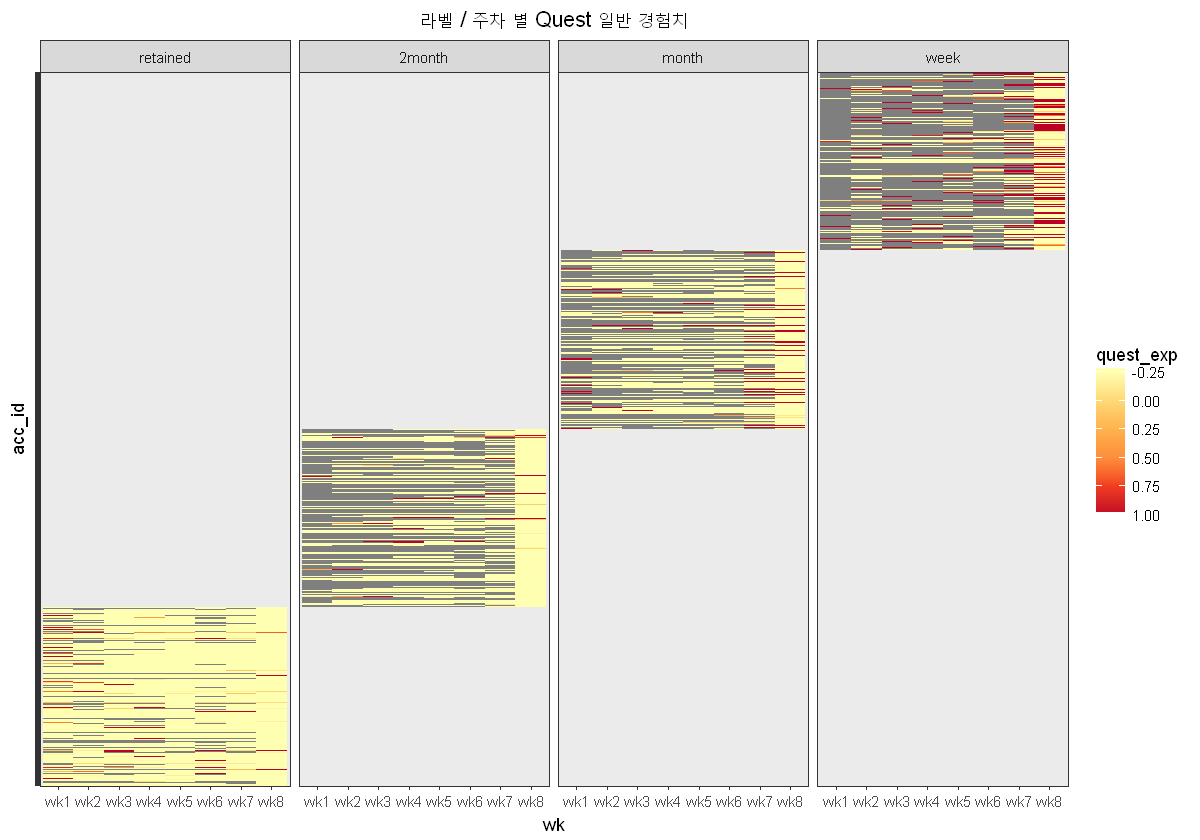

In [53]:
set.seed(6454)
label_week_heatmap(activity, "quest_exp", is_normalized = T, sample_num = 500) + labs(title = "라벨 / 주차 별 Quest 일반 경험치")

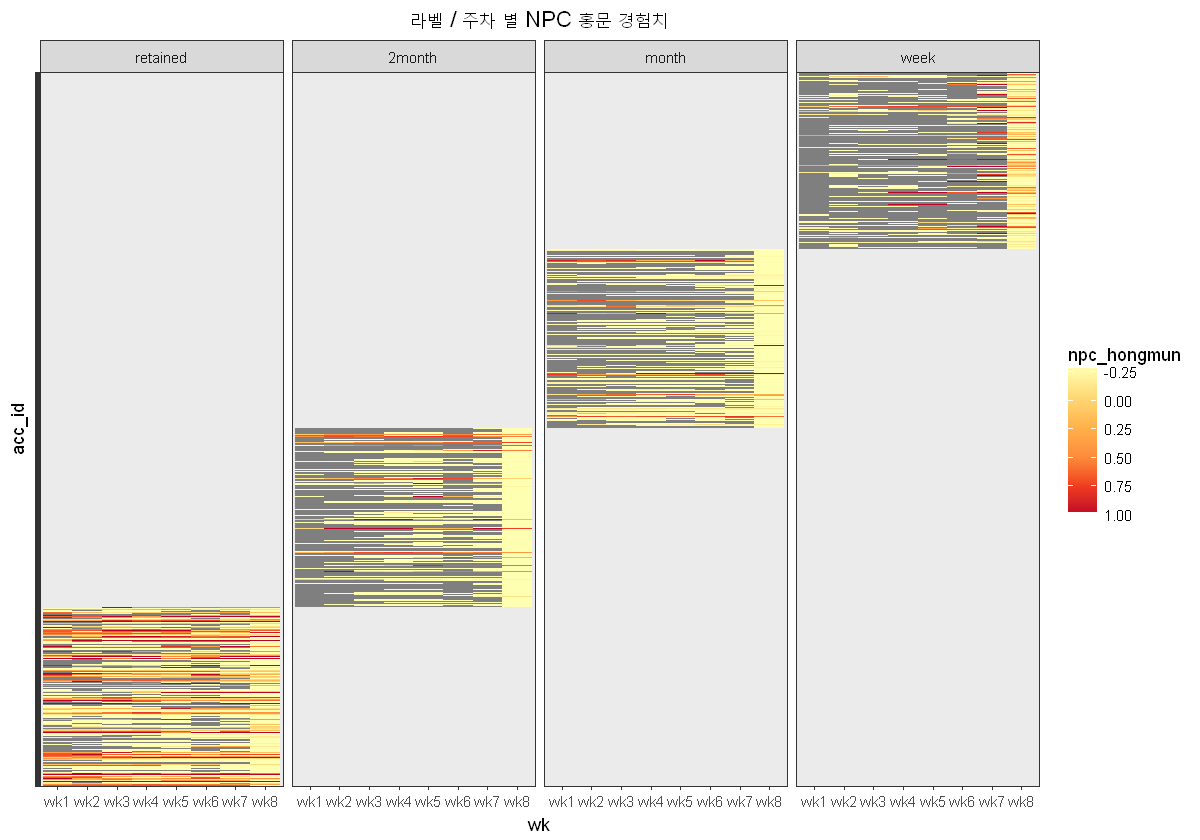

In [54]:
set.seed(6455)
label_week_heatmap(activity, "npc_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 NPC 홍문 경험치")

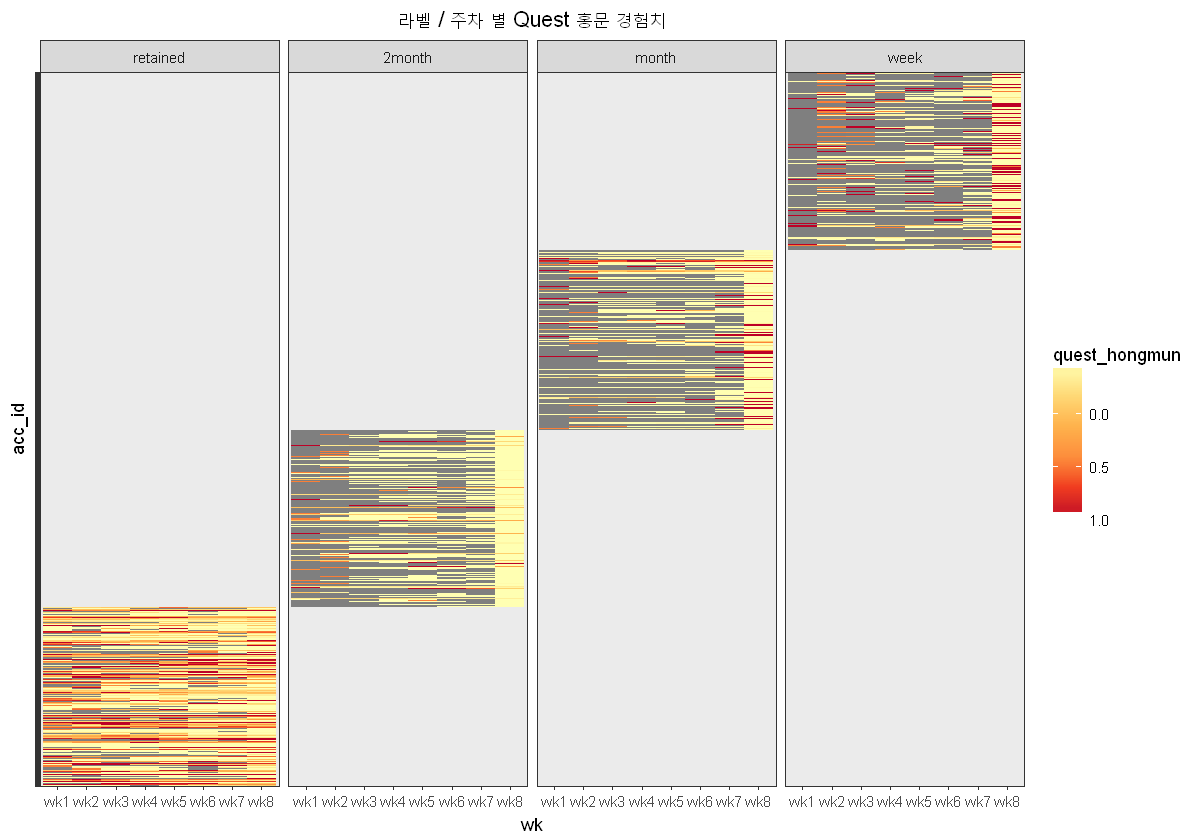

In [55]:
set.seed(6456)
label_week_heatmap(activity, "quest_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Quest 홍문 경험치")

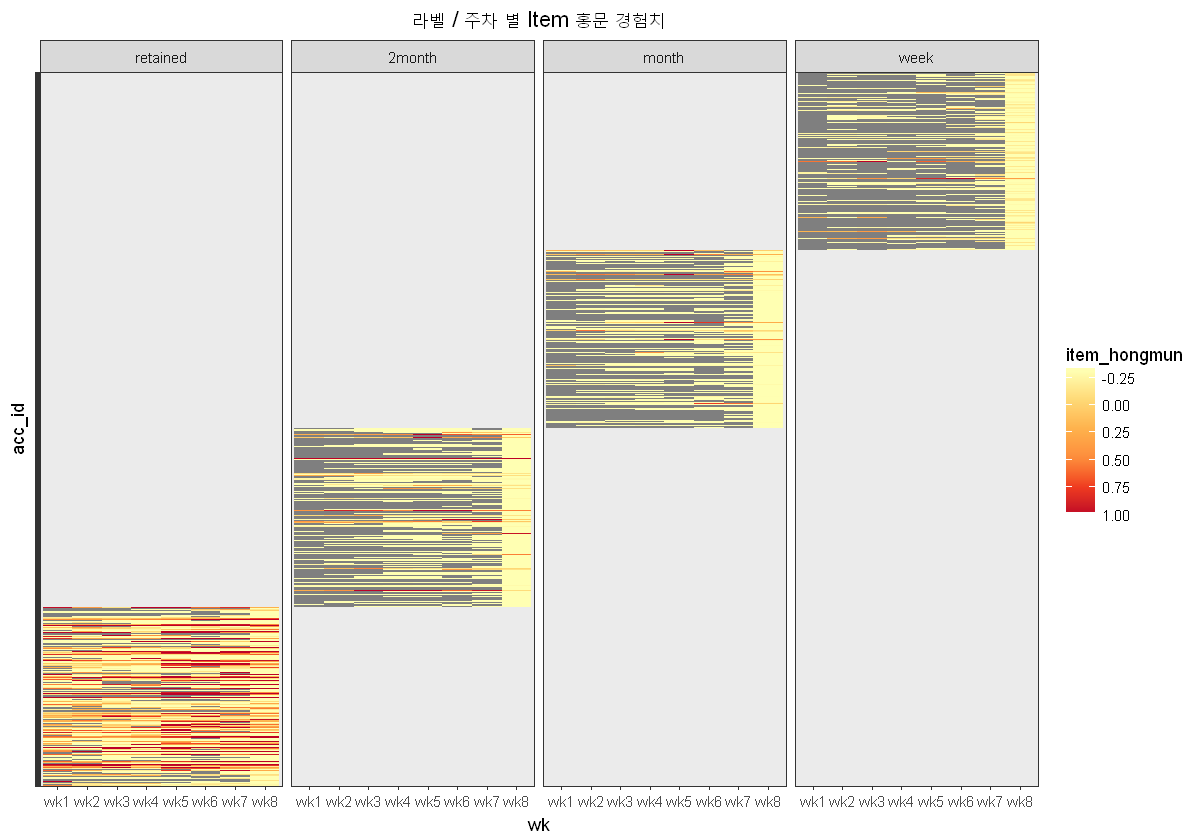

In [56]:
set.seed(6457)
label_week_heatmap(activity, "item_hongmun", is_normalized = T, sample_num = 2500) + labs(title = "라벨 / 주차 별 Item 홍문 경험치")

## 2.4 Variables about Dungeon
* cnt_enter_inzone_solo
* cnt_enter_inzone_light
* cnt_enter_inzone_noraml
* cnt_enter_inzone_skilled
* cnt_enter_raid
* cnt_enter_raid_light
* cnt_enter_bam
* cnt_clear_inzone_solo
* cnt_clear_inzone_light
* cnt_clear_inzone_skilled
* cnt_clear_inzone_noraml
* cnt_clear_raid
* cnt_clear_raid_light
* cnt_clear_bam

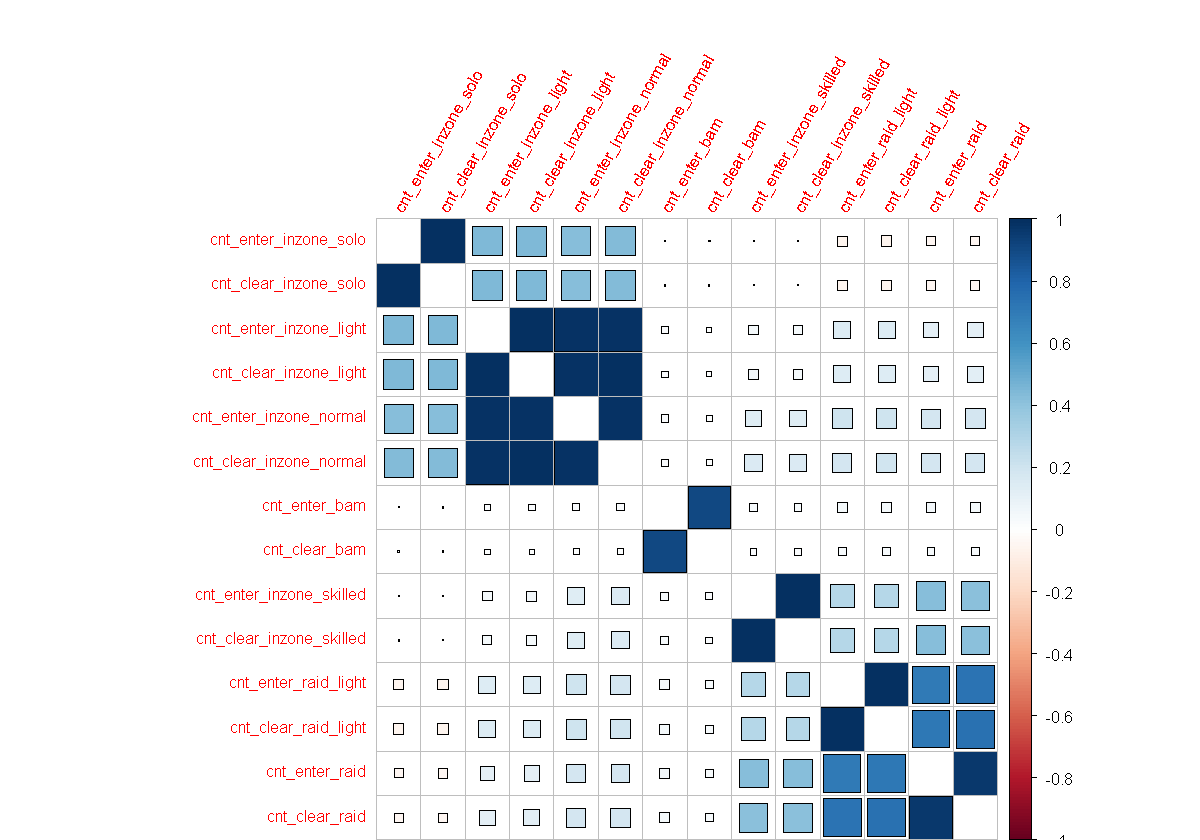

In [60]:
cor.df.temp2 <- cor(activity[,c(17:30)])
corrplot(cor.df.temp2, method = "square", order = "hclust", tl.cex = 0.8,
         tl.srt = 60, diag = F, outline = T)

In [84]:
cnt_enter_inzone_solo_temp <- activity %>% select(acc_id, wk, cnt_enter_inzone_solo) %>% spread(key = "wk", value = "cnt_enter_inzone_solo")
names(cnt_enter_inzone_solo_temp)[2:9] <- paste0("wk", 1:8)
cnt_enter_inzone_solo <- cnt_enter_inzone_solo_temp %>% gather(key = "wk", value = "value", -acc_id) %>%
  mutate(type = "cnt_enter_inzone_solo")

cnt_enter_raid_temp <- activity %>% select(acc_id, wk, cnt_enter_raid) %>% spread(key = "wk", value = "cnt_enter_raid")
names(cnt_enter_raid_temp)[2:9] <- paste0("wk", 1:8)
cnt_enter_raid <- cnt_enter_raid_temp %>% gather(key = "wk", value = "value", -acc_id) %>%
  mutate(type = "cnt_enter_raid")

all <- cnt_enter_inzone_solo %>% bind_rows(cnt_enter_raid)

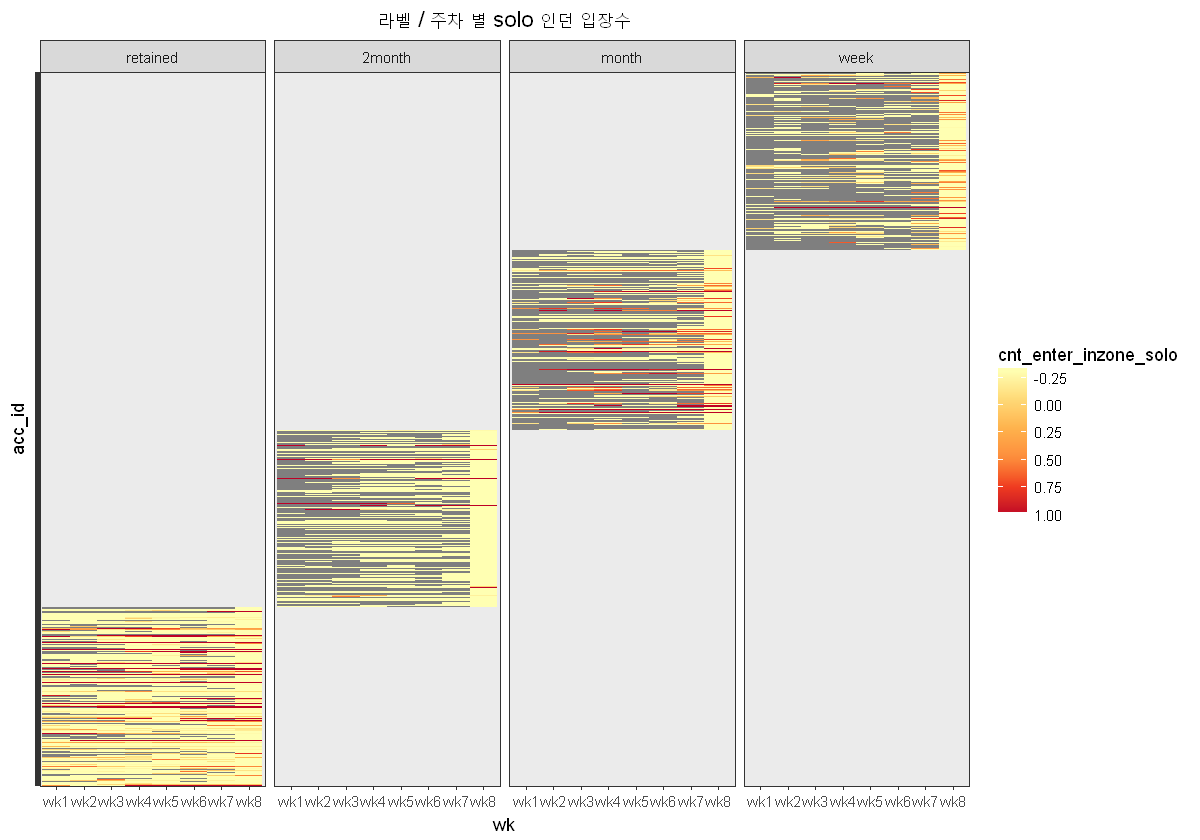

In [118]:
label_week_heatmap(activity, "cnt_enter_inzone_solo", is_normalized = T, sample_num = 500) + labs(title = "라벨 / 주차 별 solo 인던 입장수")

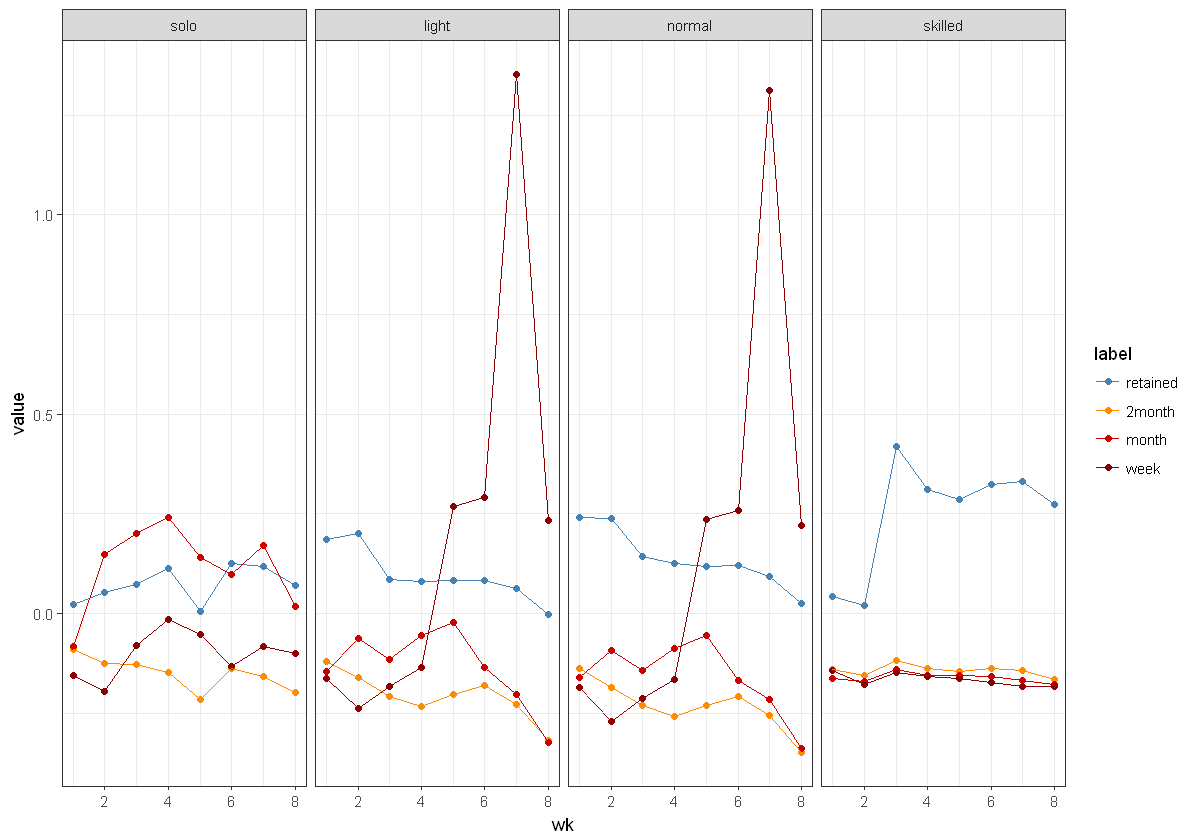

In [119]:
activity %>% left_join(label, by = "acc_id") %>% group_by(label, wk) %>%
  summarize(solo = mean(cnt_enter_inzone_solo),
            light = mean(cnt_enter_inzone_light),
            normal = mean(cnt_enter_inzone_normal),
            skilled = mean(cnt_enter_inzone_skilled)) %>%
  gather(key = "type", value = "value", -label, -wk) %>%
  mutate(type = factor(type, levels = c("solo", "light", "normal", "skilled"))) %>%
  ggplot(aes(wk, value, group = label, col = label)) + geom_point() + geom_line() + facet_grid(. ~ type) +
  scale_color_manual(name = "label", values = c("steelblue", "darkorange", "red3", "darkred"))

## 2.4 Variables about Duel/Battle
* duel_cnt
* duel_win
* partybattle_cnt
* partybattle_win

In [6]:
cor.df["play_time", c("duel_cnt", "partybattle_cnt")]

duel_cnt partybattle_cnt 
     0.05965938      0.17627055

In [6]:
cor.df["cnt_dt", c("duel_cnt", "partybattle_cnt")]

duel_cnt partybattle_cnt 
     0.03142239      0.14799442

In [7]:
battle <- activity %>% group_by(acc_id) %>% 
  summarise(duel_cnt = sum(duel_cnt),
            duel_win = sum(duel_win),
            partybattle_cnt = sum(partybattle_cnt),
            partybattle_win = sum(partybattle_win)) %>%
  right_join(label, by = "acc_id")

In [8]:
summary(battle %>% select(-acc_id))

    duel_cnt            duel_win         partybattle_cnt    
 Min.   :  -0.2893   Min.   :  -0.3306   Min.   : -1.33978  
 1st Qu.:  -0.2532   1st Qu.:  -0.2893   1st Qu.: -1.17231  
 Median :  -0.1157   Median :  -0.1393   Median : -0.50242  
 Mean   :   0.0108   Mean   :   0.0100   Mean   : -0.00287  
 3rd Qu.:  -0.0362   3rd Qu.:  -0.0413   3rd Qu.: -0.16747  
 Max.   :1358.6236   Max.   :1442.4657   Max.   :161.84923  
 partybattle_win          label      
 Min.   : -1.27898   retained:25000  
 1st Qu.: -1.11911   2month  :25000  
 Median : -0.47962   month   :25000  
 Mean   : -0.00086   week    :25000  
 3rd Qu.: -0.15987                   
 Max.   :169.89448                   

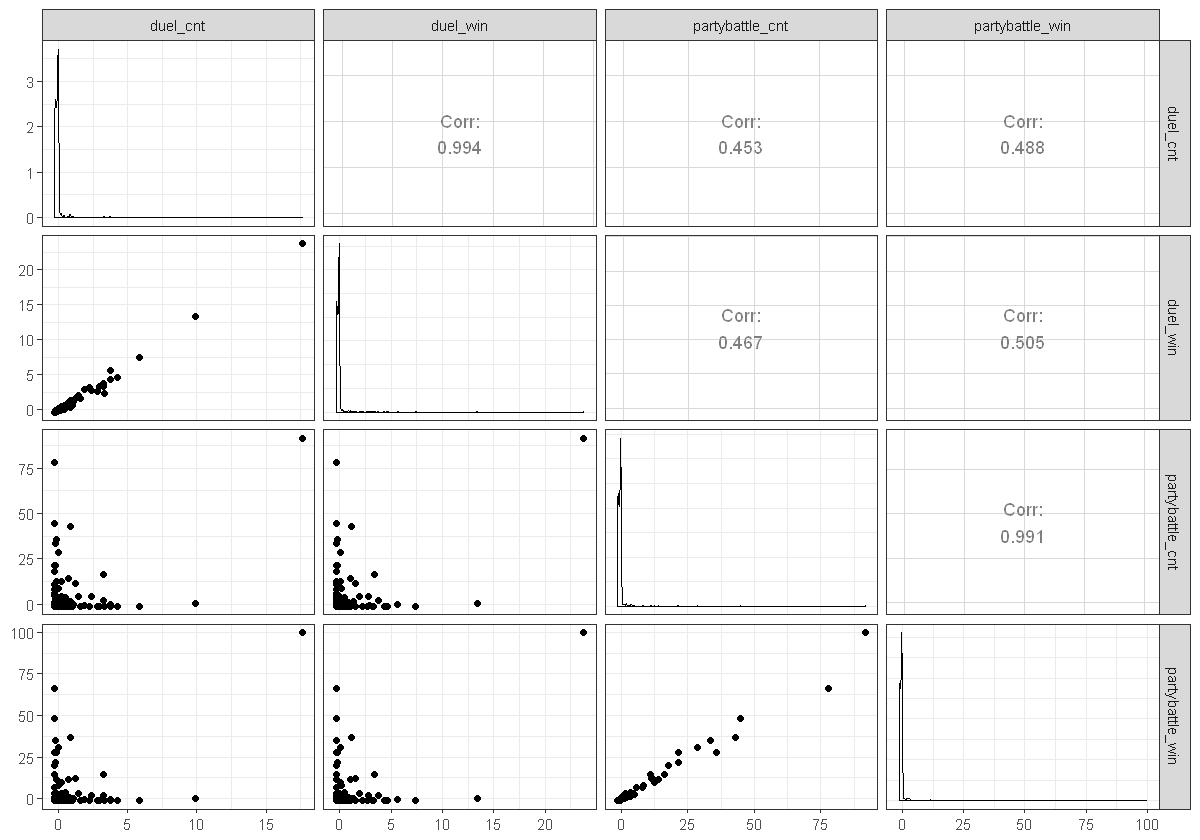

In [15]:
ggpairs(battle %>% sample_n(1000), 
        columns = c("duel_cnt", "duel_win", "partybattle_cnt", "partybattle_win"))

### 2.4.1 Is Duel User?

In [10]:
duel <- activity %>% group_by(acc_id) %>% 
  summarise(sum_duel_cnt = sum(duel_cnt)) %>%
  mutate(threshold_0.1 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.1), 1,  0),
         threshold_0.2 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.2), 1,  0),
         threshold_0.3 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.3), 1,  0),
         threshold_0.4 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.4), 1,  0),
         threshold_0.5 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.5), 1,  0),
         threshold_0.6 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.6), 1,  0),
         threshold_0.7 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.7), 1,  0),
         threshold_0.8 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.8), 1,  0),
         threshold_0.9 = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.9), 1,  0)) %>%
  right_join(label, by = "acc_id") %>%
  gather(key = "threshold", value = "value", -acc_id, -sum_duel_cnt, -label) %>% 
  group_by(threshold, label) %>% summarize(duel_rate = sum(value)/n()) %>% ungroup() %>%
  mutate(threshold = factor(threshold, levels = c("threshold_0.1", "threshold_0.2", "threshold_0.3", 
                                                  "threshold_0.4", "threshold_0.5", "threshold_0.6", 
                                                  "threshold_0.7", "threshold_0.8", "threshold_0.9")))

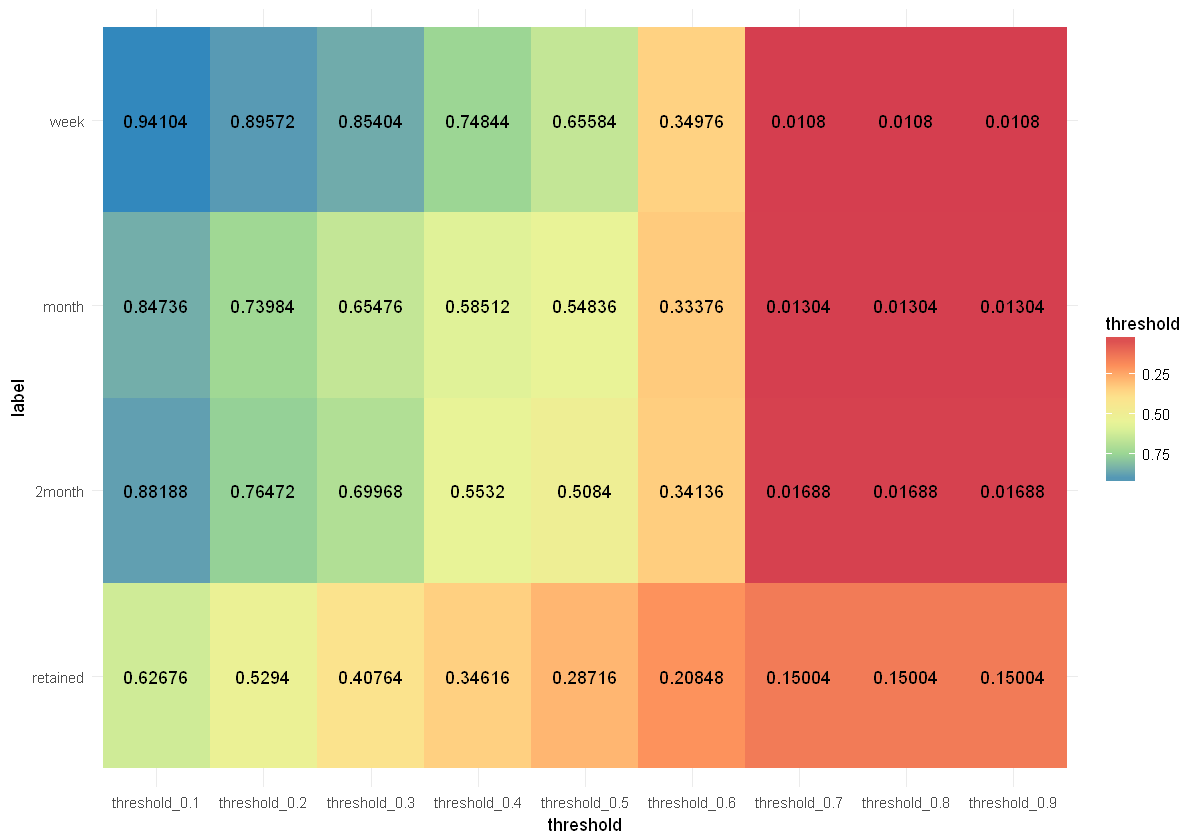

In [16]:
ggplot(duel, aes(threshold, label, fill = duel_rate)) + 
  geom_tile() + geom_text(aes(label = duel_rate)) +
  scale_fill_distiller(name = "threshold", palette = "Spectral", tran = "reverse") +
  theme_minimal()

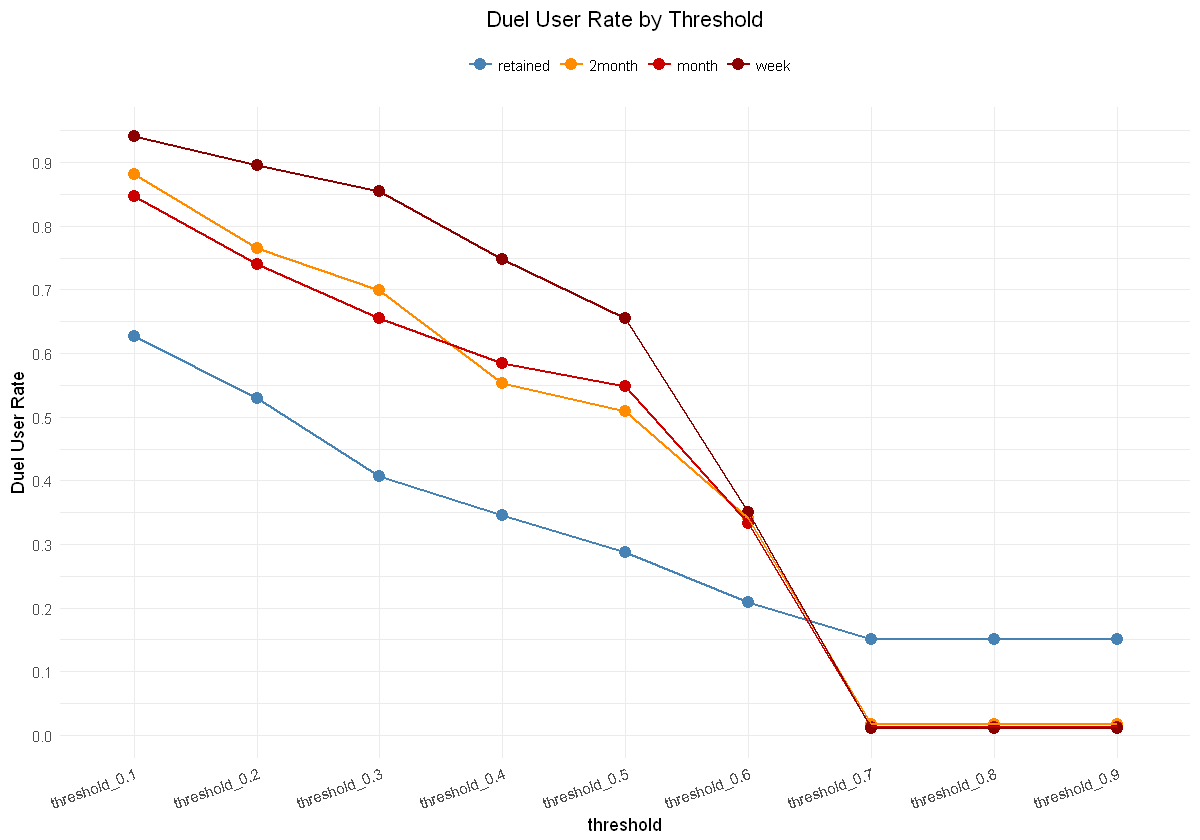

In [19]:
ggplot(duel) + 
  geom_point(aes(threshold, duel_rate, group = label, col = label), size = 3) +
  geom_line(aes(threshold, duel_rate, group = label, col = label), size = 0.7) +
  scale_y_continuous(breaks = round(seq(0, 1, length.out = 11), 1)) +
  theme_minimal() +
  labs(title = "Duel User Rate by Threshold", y = "Duel User Rate") +
  scale_color_manual(name = "",
                     values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(legend.position = "top", axis.text.x = element_text(angle=20, hjust=1), plot.title = element_text(hjust = 0.5))

In [20]:
duel_temp <- duel %>% 
  filter(label != "retained") %>%
  group_by(threshold) %>% 
  summarize(duel_rate = mean(duel_rate)) %>%
  mutate(label = "churn") %>%
  select(threshold, label, duel_rate) %>%
  bind_rows(duel %>% mutate(label = as.character(label)) %>% filter(label == "retained"))

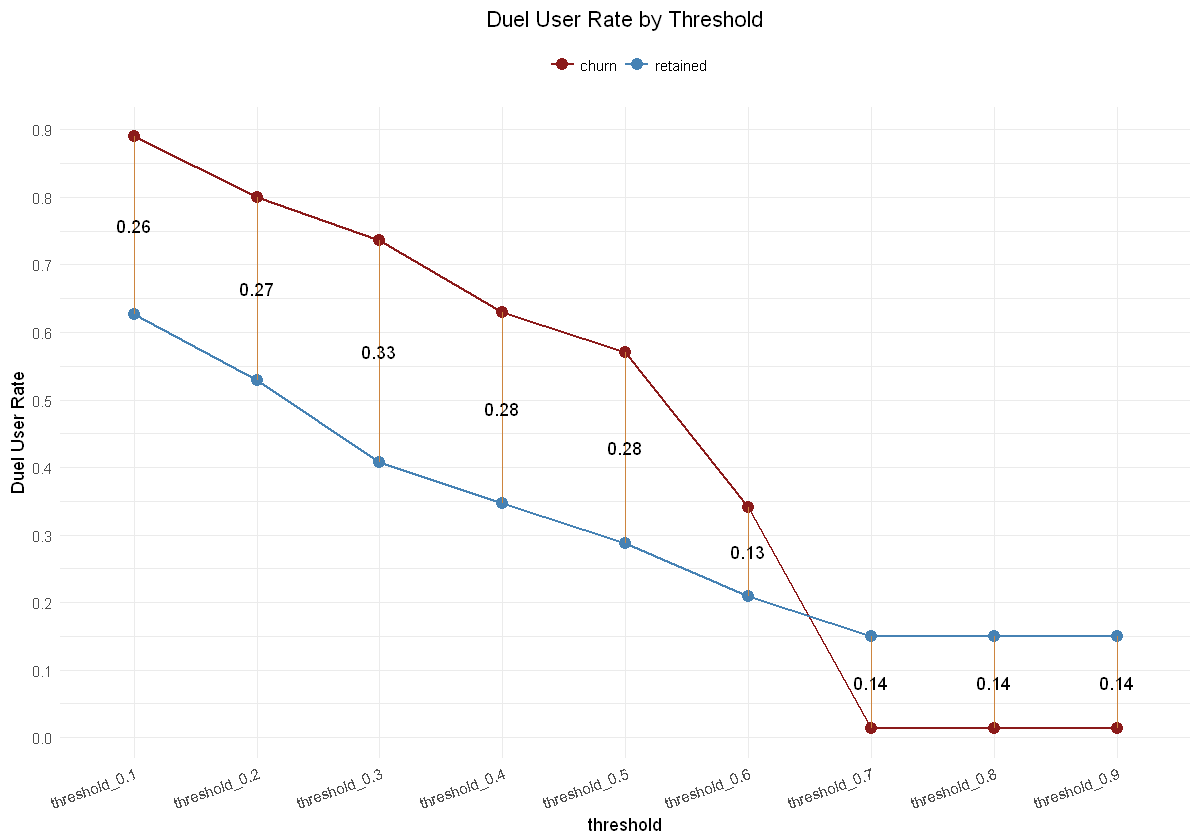

In [22]:
duel_temp %>% group_by(threshold) %>%
  spread(key = "label", value = "duel_rate") %>%
  mutate(diff = round(abs(retained - churn), 2),
         mean = (churn + retained)/2) %>%
  ggplot() + geom_point(aes(threshold, churn, col = "churn"), size = 3) +
  geom_line(aes(threshold, churn, col = "churn", group = 1), size = 0.7) +
  geom_point(aes(threshold, retained, col = "retained"), size = 3) +
  geom_line(aes(threshold, retained, col = "retained", group = 1), size = 0.7) +
  geom_segment(aes(x = threshold, y = churn,
                   xend = threshold, yend = retained), col = "peru") +
  geom_text(aes(label = diff, x = threshold, y = mean)) +
  theme_minimal() +
  scale_y_continuous(breaks = round(seq(0, 1, length.out = 11), 1)) +
  labs(title = "Duel User Rate by Threshold", y = "Duel User Rate") +
  scale_color_manual(name = "",
                     values = c("retained" = "steelblue",
                                "churn" = "firebrick4")) +
  theme(legend.position = "top", axis.text.x = element_text(angle=20, hjust=1), plot.title = element_text(hjust = 0.5))

In [23]:
duel2 <- activity %>% group_by(acc_id) %>% 
  summarise(mean_duel_cnt = mean(duel_cnt)) %>%
  mutate(threshold_0.1 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.1), 1,  0),
         threshold_0.2 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.2), 1,  0),
         threshold_0.3 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.3), 1,  0),
         threshold_0.4 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.4), 1,  0),
         threshold_0.5 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.5), 1,  0),
         threshold_0.6 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.6), 1,  0),
         threshold_0.7 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.7), 1,  0),
         threshold_0.8 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.8), 1,  0),
         threshold_0.9 = ifelse(mean_duel_cnt > quantile(mean_duel_cnt, 0.9), 1,  0)) %>%
  right_join(label, by = "acc_id") %>%
  gather(key = "threshold", value = "value", -acc_id, -mean_duel_cnt, -label) %>% 
  group_by(threshold, label) %>% summarize(duel_rate = sum(value)/n()) %>% ungroup() %>%
  mutate(threshold = factor(threshold, levels = c("threshold_0.1", "threshold_0.2", "threshold_0.3", 
                                                  "threshold_0.4", "threshold_0.5", "threshold_0.6", 
                                                  "threshold_0.7", "threshold_0.8", "threshold_0.9")))

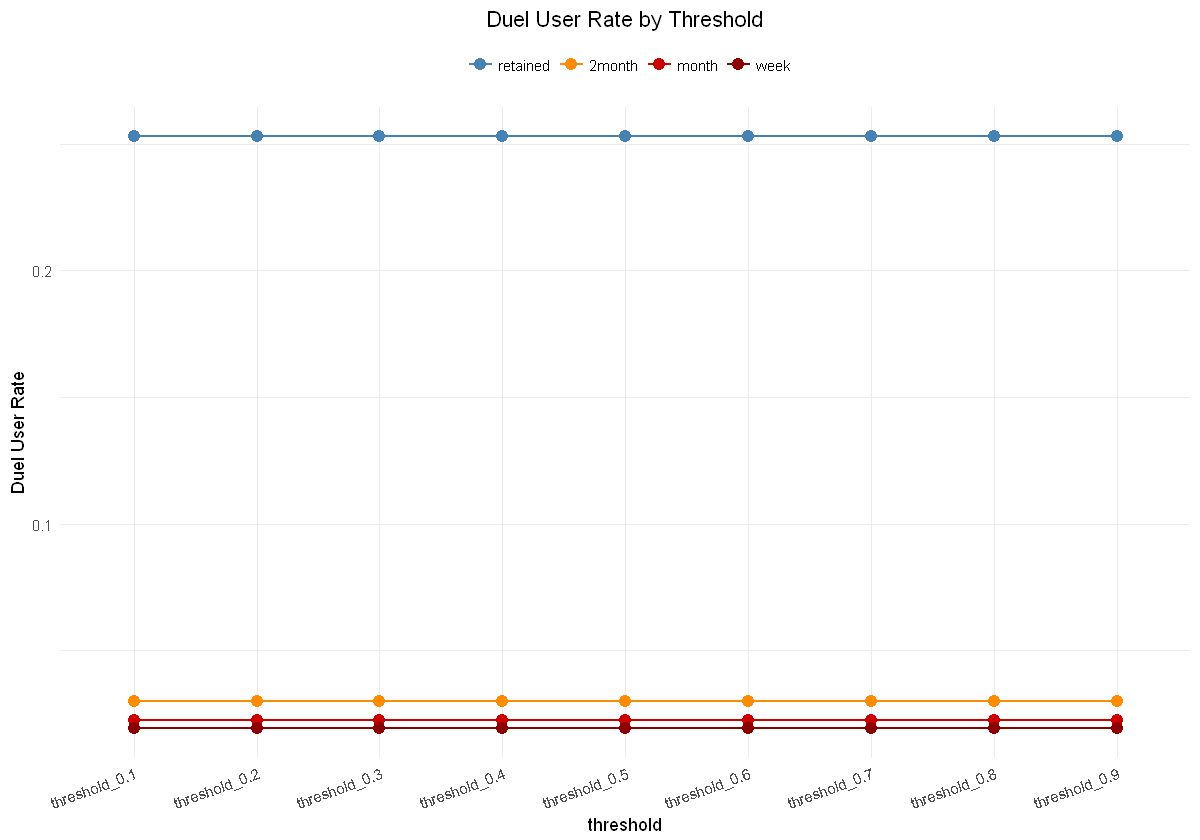

In [24]:
ggplot(duel2) + 
  geom_point(aes(threshold, duel_rate, group = label, col = label), size = 3) +
  geom_line(aes(threshold, duel_rate, group = label, col = label), size = 0.7) +
  scale_y_continuous(breaks = round(seq(0, 1, length.out = 11), 1)) +
  theme_minimal() +
  labs(title = "Duel User Rate by Threshold", y = "Duel User Rate") +
  scale_color_manual(name = "",
                     values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme(legend.position = "top", axis.text.x = element_text(angle=20, hjust=1), plot.title = element_text(hjust = 0.5))

In [25]:
temp <- activity %>% group_by(acc_id) %>% 
  summarise(mean_duel_cnt = mean(duel_cnt),
            sum_duel_cnt = sum(duel_cnt)) %>%
  mutate(mean_is_duel = ifelse(mean_duel_cnt < -0.036, 0, 1) %>% factor(),
         sum_is_duel  = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.3), 1, 0) %>% factor()) %>%
  left_join(label, by = "acc_id") %>% 
  gather(key = "type", value = "value", -acc_id, -mean_duel_cnt, -sum_duel_cnt, -label)

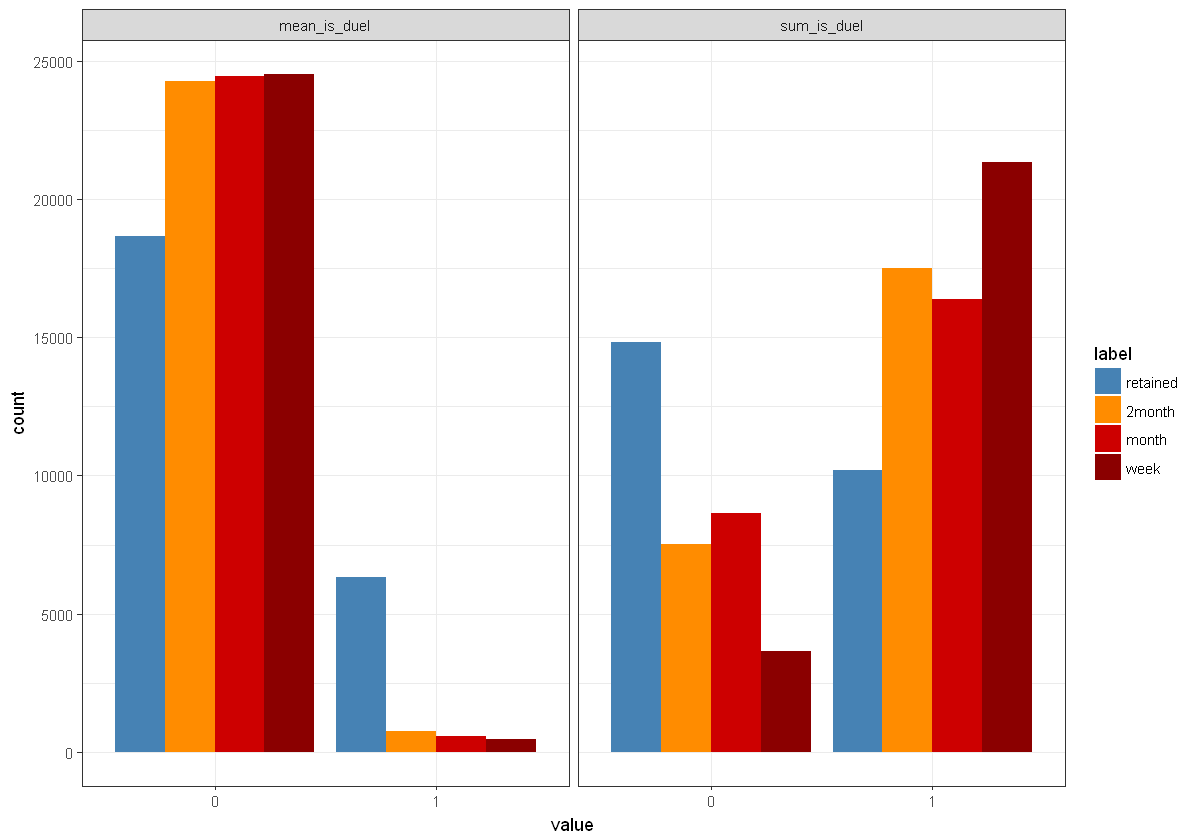

In [26]:
ggplot(temp) + geom_bar(aes(value, fill = label), position = "dodge") + facet_grid(. ~ type) +
  scale_fill_manual(name = "label",
                    values = c("steelblue", "darkorange", "red3", "darkred"))

### 2.4.2 Is Partybattle User?

In [27]:
partybattle <- activity %>% group_by(acc_id) %>% 
  summarise(sum_partybattle_cnt = sum(partybattle_cnt)) %>%
  mutate(threshold_0.1 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.1), 1,  0),
         threshold_0.2 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.2), 1,  0),
         threshold_0.3 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.3), 1,  0),
         threshold_0.4 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.4), 1,  0),
         threshold_0.5 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.5), 1,  0),
         threshold_0.6 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.6), 1,  0),
         threshold_0.7 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.7), 1,  0),
         threshold_0.8 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.8), 1,  0),
         threshold_0.9 = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.9), 1,  0)) %>%
  right_join(label, by = "acc_id") %>%
  gather(key = "threshold", value = "value", -acc_id, -sum_partybattle_cnt, -label) %>% 
  group_by(threshold, label) %>% summarize(partybattle_rate = sum(value)/n()) %>% ungroup() %>%
  mutate(threshold = factor(threshold, levels = c("threshold_0.1", "threshold_0.2", "threshold_0.3", 
                                                  "threshold_0.4", "threshold_0.5", "threshold_0.6", 
                                                  "threshold_0.7", "threshold_0.8", "threshold_0.9")))

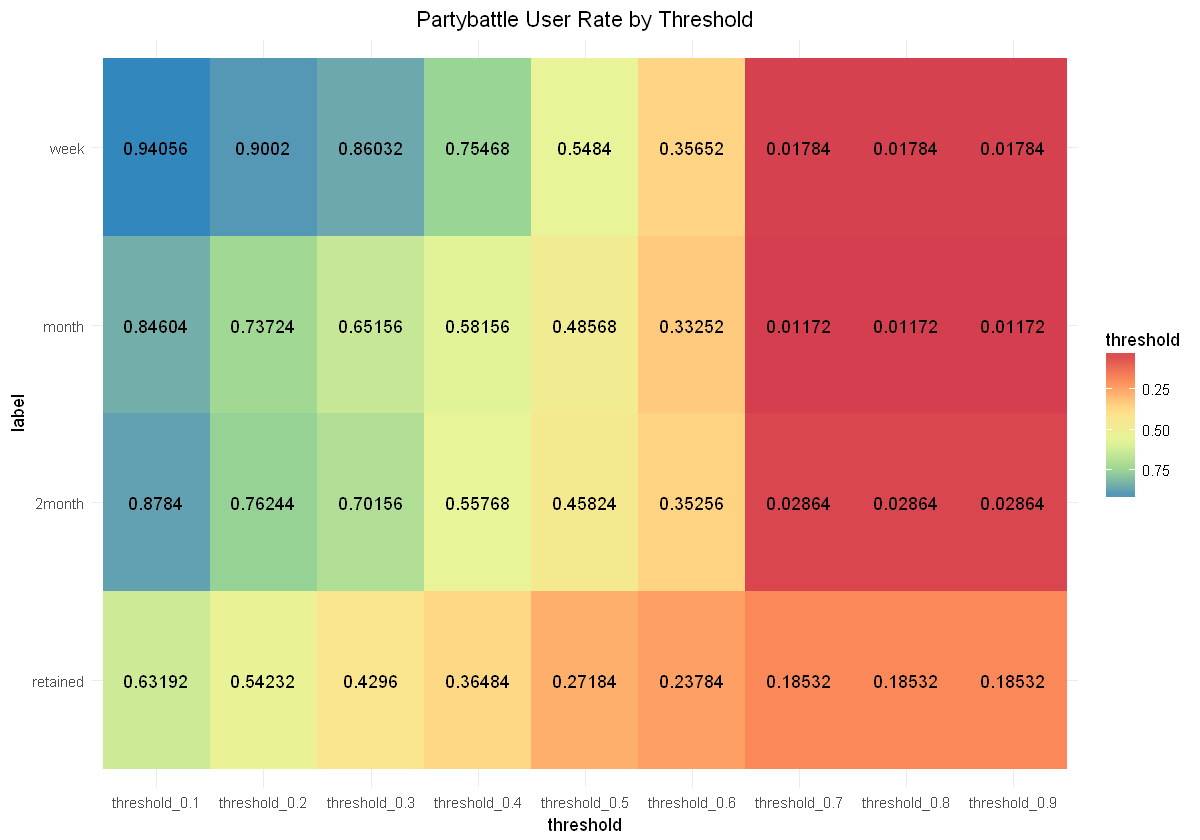

In [28]:
ggplot(partybattle, aes(threshold, label, fill = partybattle_rate)) + 
  geom_tile() + geom_text(aes(label = partybattle_rate)) +
  theme(axis.text.x = element_text(angle=50, hjust=1)) +
  scale_fill_distiller(name = "threshold", palette = "Spectral", tran = "reverse") +
  theme_minimal() + labs(title = "Partybattle User Rate by Threshold") +
  theme(plot.title = element_text(hjust = 0.5))

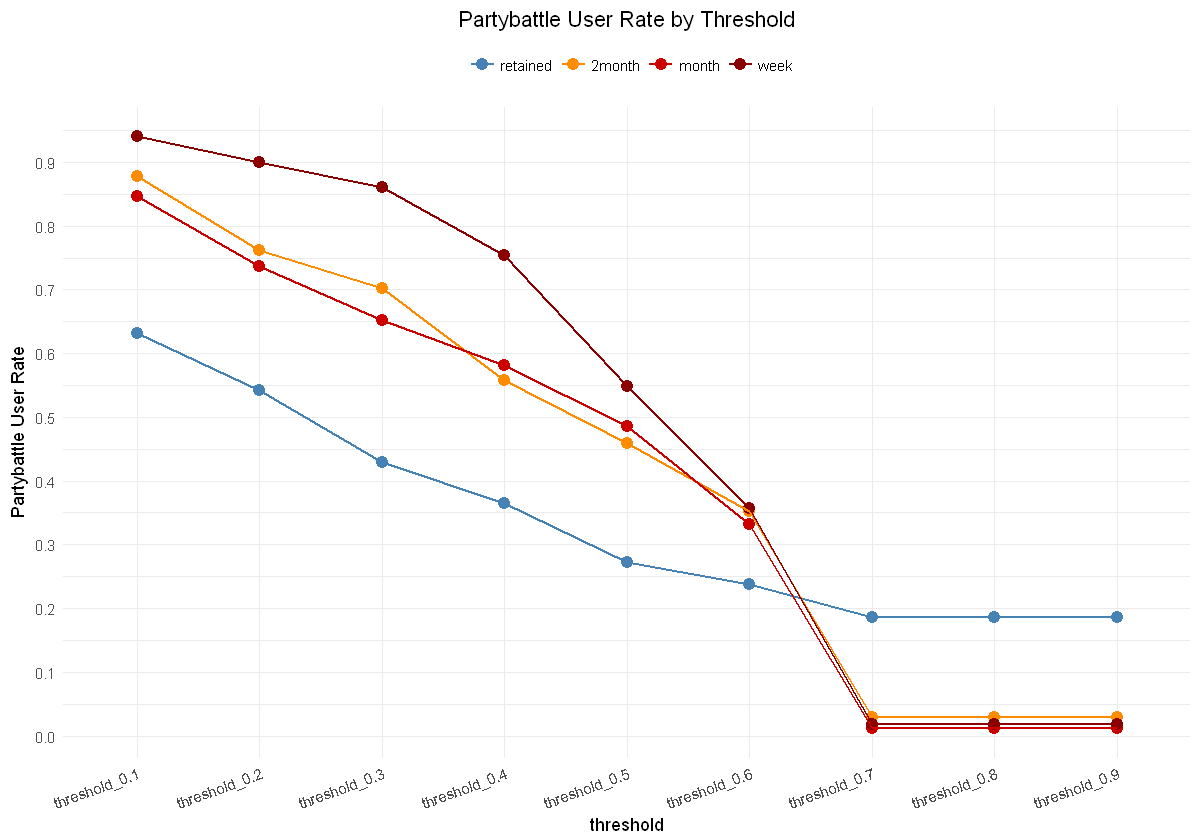

In [29]:
ggplot(partybattle) + 
  geom_point(aes(threshold, partybattle_rate, group = label, col = label), size = 3) +
  geom_line(aes(threshold, partybattle_rate, group = label, col = label), size = 0.7) +
  scale_y_continuous(breaks = round(seq(0, 1, length.out = 11), 1)) +
  theme_minimal() +
  labs(title = "Partybattle User Rate by Threshold", y = "Partybattle User Rate") +
  scale_color_manual(name = "",
                     values = c("steelblue", "darkorange", "red3", "darkred")) +
  theme_minimal() + theme(legend.position = "top", 
                          axis.text.x = element_text(angle=20, hjust=1),
                          plot.title = element_text(hjust = 0.5))

In [30]:
partybattle_temp <- partybattle %>% 
  filter(label != "retained") %>%
  group_by(threshold) %>% 
  summarize(partybattle_rate = mean(partybattle_rate)) %>%
  mutate(label = "churn") %>%
  select(threshold, label, partybattle_rate) %>%
  bind_rows(partybattle %>% mutate(label = as.character(label)) %>% filter(label == "retained"))

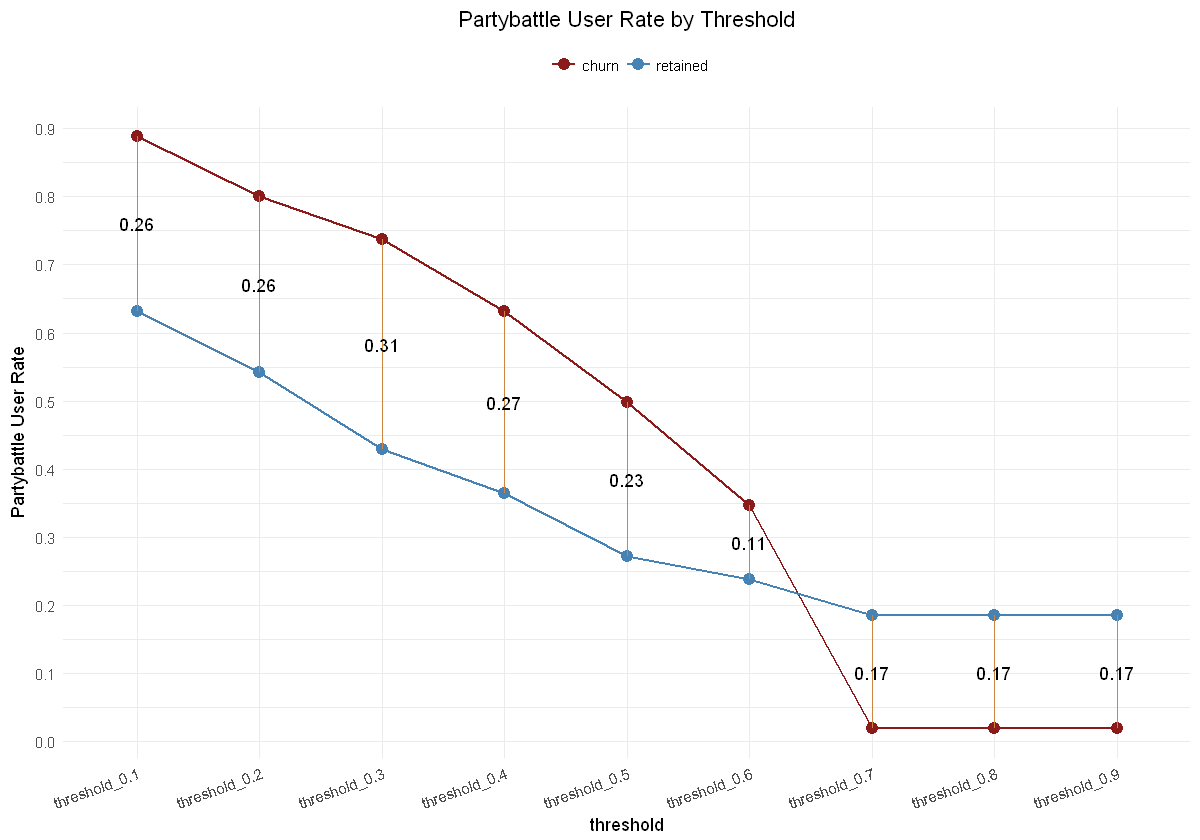

In [31]:
partybattle_temp %>% group_by(threshold) %>%
  spread(key = "label", value = "partybattle_rate") %>%
  mutate(diff = round(abs(retained - churn), 2),
         mean = (churn + retained)/2) %>%
  ggplot() + geom_point(aes(threshold, churn, col = "churn"), size = 3) +
  geom_line(aes(threshold, churn, col = "churn", group = 1), size = 0.7) +
  geom_point(aes(threshold, retained, col = "retained"), size = 3) +
  geom_line(aes(threshold, retained, col = "retained", group = 1), size = 0.7) +
  geom_segment(aes(x = threshold, y = churn,
                   xend = threshold, yend = retained), col = "peru") +
  geom_text(aes(label = diff, x = threshold, y = mean)) +
  scale_y_continuous(breaks = round(seq(0, 1, length.out = 11), 1)) +
  labs(title = "Partybattle User Rate by Threshold", y = "Partybattle User Rate") +
  scale_color_manual(name = "",
                     values = c("retained" = "steelblue",
                                "churn" = "firebrick4")) +
  theme_minimal() + theme(legend.position = "top", 
                          axis.text.x = element_text(angle=20, hjust=1),
                          plot.title = element_text(hjust = 0.5))

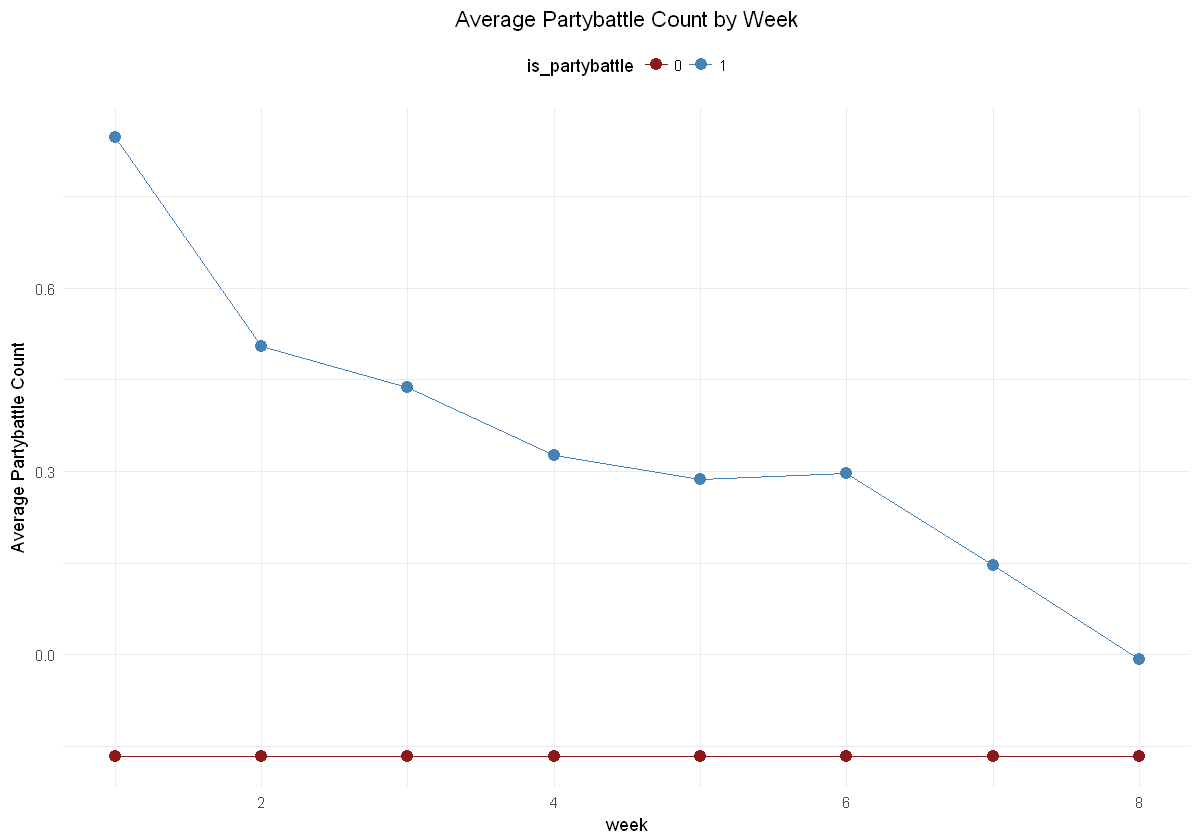

In [32]:
temp1 <- battle %>% mutate(partybattle = ifelse(partybattle_cnt > quantile(partybattle_cnt, 0.3), 1, 0) %>% factor())
temp2 <- activity %>% left_join(temp1 %>% select(partybattle, acc_id, label), by = "acc_id") %>% 
  select(acc_id, wk, partybattle_cnt, partybattle, label)
temp3 <- temp2 %>% group_by(partybattle, wk) %>% summarize(mean = mean(partybattle_cnt))
ggplot(temp3) + geom_point(aes(wk, mean, col = partybattle), size = 3) + geom_line(aes(wk, mean, col = partybattle, group = partybattle)) +
  scale_color_manual(name = "is_partybattle", values = c("1" = "steelblue", "0" = "firebrick4")) + 
  labs(x = "week", y = "Average Partybattle Count", title = "Average Partybattle Count by Week") +
  theme_minimal() + theme(legend.position = "top", plot.title = element_text(hjust = 0.5))

### 2.2.3 Duel - Partybattle User

In [33]:
test <- battle %>% mutate(duel = ifelse(duel_cnt > quantile(duel_cnt, 0.3), 1, 0) %>% factor(),
                          partybattle = ifelse(partybattle_cnt > quantile(partybattle_cnt, 0.3), 1, 0) %>% factor(),
                         type = ifelse(duel == 1 & partybattle == 1, "both",
                                      ifelse(duel == 1 & partybattle == 0, "duel",
                                            ifelse(duel == 0 & partybattle == 1, "partybattle", "none"))) %>% 
                          factor(levels = c("both", "duel", "partybattle", "none")))

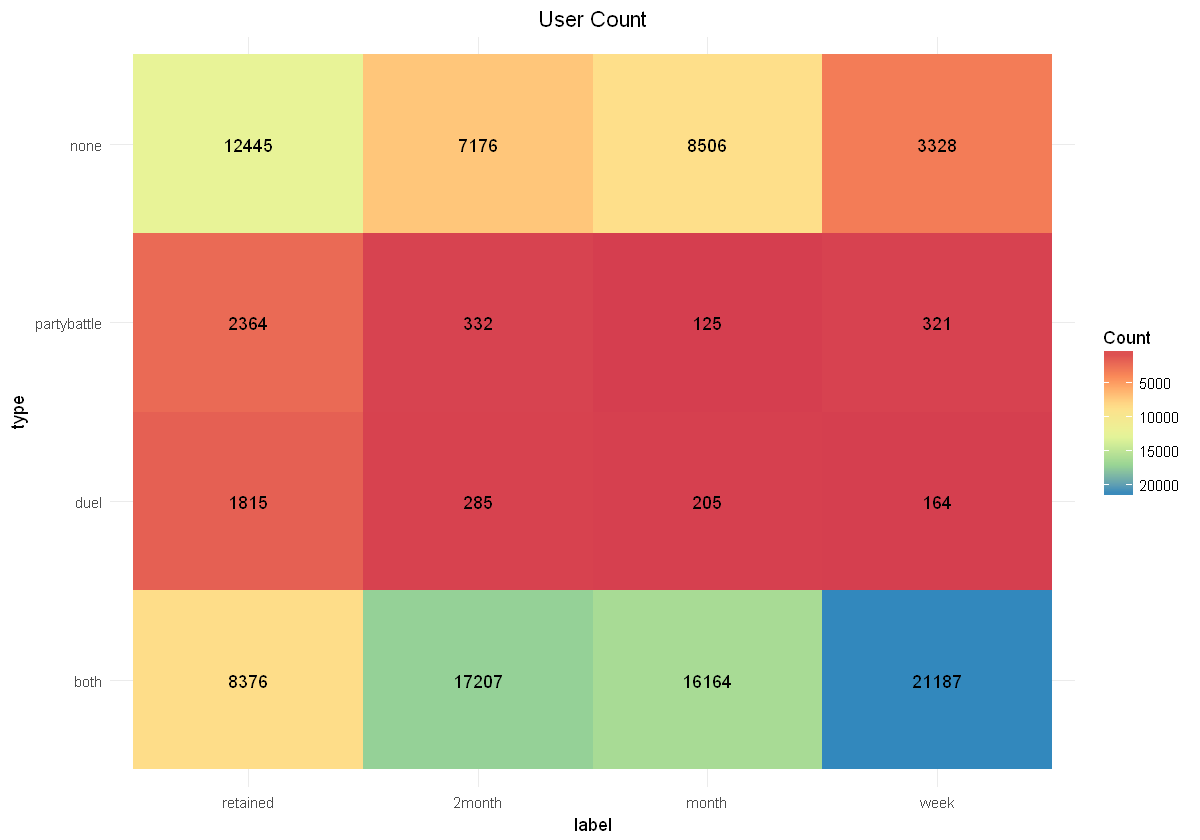

In [34]:
table(test$type, test$label) %>% data.frame() %>%
  ggplot(aes(Var2, Var1, fill = Freq)) + geom_tile() + geom_text(aes(label = Freq)) +
  scale_fill_distiller(name = "Count", palette = "Spectral", tran = "reverse") +
  labs(title = "User Count", x = "label", y = "type") + theme_minimal() + theme(plot.title = element_text(hjust = 0.5))